In [1]:
# !pip install imageio # for GIF making
import os
import glob as glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['text.usetex']=False

# Set-up (Parameter as a Dictionary)

In [2]:
path_to_save_figures = os.path.expanduser("~/Desktop/Grumbach Hilker Allee Pit/Figures for total population against dispersal rates/")

In [3]:
# Variables according to Appendix 1: Numerical Methods for Figure 4.1
N_A = 1.0
N_B = 1.0

# total theoretical Capacity
N_tot = N_A + N_B

# number of simulation steps according to A1
no_timesteps = 500

# Here we save the results
results = np.zeros(no_timesteps + 1)

## Growth Functions

These are the growth functions (not to be confused with Step functions). They represent the growth rate / function assumed by an Beverlton-Holt part and a mate-finding Allee-effect. 
$$ f_i(N_i) = \frac{r_i \cdot N_i}{1+\xi_i \cdot N_i} \cdot \frac{N_i}{N_i + \Theta}  $$

In [4]:
# Growth-function pitch A
def f_A(N_A_t, params):
    # growth function with Beverlton-Holt part * mate-finding part
    #        BH                              *  Matefinding
    return (((params['r_A'] * N_A_t)/(1 + params['xi_A'] * N_A_t)) * (N_A_t / (N_A_t + params['Theta'])))


In [5]:
# Growth-function pitch B
def f_B(N_B_t, params):
    # growth function with Beverlton-Holt part * mate-finding part
    #        BH                              *  Matefinding
    return (((params['r_B'] * N_B_t)/(1 + params['xi_B'] * N_B_t)) * (N_B_t / (N_B_t + params['Theta'])))

## Step functions

The step functions on the other hand are essentially the
taking mainly into account the above described growth functions. In addition to these growth functions a dispersal rate determines, how much of the "grown" population migrates to the other patch.

In [6]:
# Step function for N_A
# , disp, Allee-Strength shouldnt be fixed
def N_A_t_1 (N_A_t, N_B_t, params):
    # return next value
    return ((1 - params['disp']) * f_A(N_A_t, params) + params['disp'] * f_B(N_B_t, params))

In [7]:
# Step function for N_B
# disp, Allee-Strength shouldnt be fixed
def N_B_t_1 (N_A_t, N_B_t, params):
    # return next value
    return ((1 - params['disp']) * f_B(N_B_t, params) + params['disp'] * f_A(N_A_t, params))

## Function: Calculate $\xi$

In [8]:
# To obtain xi out of the Beverlton-Holt capacity
def calculate_xi(K_H_BH, r):
    return ((r - 1) / K_H_BH)

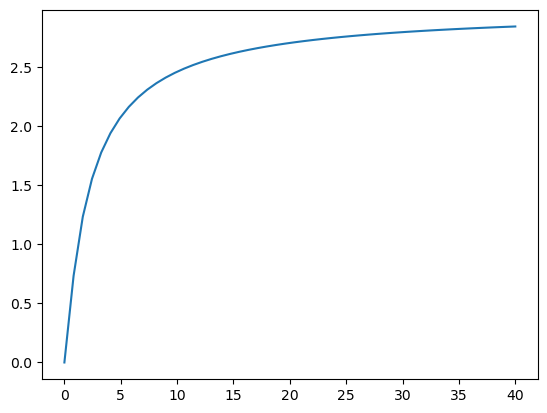

In [9]:
N_A_t = np.linspace(0,40,50)
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}

# Update parameter
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

f_A_vals = np.array([f_A(x, params) for x in N_A_t])

plt.plot(N_A_t, f_A_vals)

# Reproducing Figure 3

## Function: Plot both populations

In [10]:
def plot_N_A_N_B(results, params, show_graph_instantly = True, show_legend = True):
    
    # Create timevariable
    timesteps = np.arange(0,no_timesteps)
    fig, ax = plt.subplots()
    ax.plot(timesteps, results[:,0])
    ax.plot(timesteps, results[:,1])
    ax.set(xlabel='$N_A$', ylabel='$N_B$')
    ax.set_title((f" Dynamics in the discrete Two-Patch dispersal model \n with dispersal-rate: {np.round(params['disp'],2)}"))
    if(show_legend):
        ax.legend(["$N_A$", "$N_B$"])
    if(show_graph_instantly):
        plt.show()
    fig.tight_layout()
    # Return
    return fig, ax
   


## Function: Plot Trajectory

In [11]:
def plot_trajectory(results, plot_trajectory_instantly = True, show_legend = False):
    # check for shape of the results: should be two dimensional
    if not(len(results[0])==2):
        print(f"PLOT Trajectory: An array with wrong dimensions was given. It must be of shape (2,), but {results.shape} was given.")
        return
    else:
        alpha = 0.3
        plt.scatter(results[0][0], results[0][1], label = f"Initial conditions ({np.round(results[0][0], 2)}, {np.round(results[0][1], 2)})", s = 2, alpha = alpha)
        plt.plot(results[:,0], results[:,1], label="Trajectory of ic: $(N_A, N_B)$", alpha = alpha)
        # plot last point (~equilibrium)
        plt.scatter(results[-1][0], results[-1][1], label = f"Final iteration ({np.round(results[-1][0], 2)}, {np.round(results[-1][1], 2)})", s = 8)
        plt.xlabel("$N_A$")
        plt.ylabel("$N_B$")
        plt.xlim(0,4)
        plt.ylim(0,4)
        plt.title("Trajectory of the discrete simulation")
        if (show_legend):
            plt.legend(loc = "best")
        if(plot_trajectory_instantly):
            plt.show()

## Function: Simulate and calculate temporal results

In [12]:
# VARIANT 2.0 
# Simulation procedure
# Returns a twodimensional array (no_timesteps, 2) where [:,0] is N_A and [:,1] is N_B
def simulation(params, print_params = False, plot = False, plotting_trajectory = False, plot_instantly = True, plot_trajectory_instantly = True):
    # Reset
    results = np.zeros((no_timesteps,2))

    # Print Parameters if wanted
    if(print_params):
        print("\n" + "="*40)
        print(f"{'Parameter':<10} | {'Value':<10}")
        print("="*40)
        print(f"{'N_A':<10} | {params['N_A']:<10.2f}")
        print(f"{'N_B':<10} | {params['N_B']:<10.2f}")
        print(f"{'Theta':<10} | {params['Theta']:<10.2f}")
        print(f"{'r_A':<10} | {params['r_A']:<10.2f}")
        print(f"{'r_B':<10} | {params['r_B']:<10.2f}")
        print(f"{'Xi_A':<10} | {params['xi_A']:<10}")  # Keeping as generic value
        print(f"{'Xi_B':<10} | {params['xi_B']:<10}")  # Keeping as generic value
        print(f"{'delta':<10} | {params['disp']:<10.2f}")
        print("="*40 + "\n")
    
    
    # space for current state
    # initialization with the initial condition 1.0, 1.0 
    N_t = np.array([params['N_A'], params['N_B']])

    # simulation looping
    for i in range(no_timesteps):
        
        # Save
        results[i][0] = N_t[0]
        results[i][1] = N_t[1]

        # Calculate next step
        N_A_next = N_A_t_1(N_t[0], N_t[1], params)
        N_B_next = N_B_t_1(N_t[0], N_t[1], params)
        # Update
        N_t = np.array([N_A_next, N_B_next])

    # Plotting if wanted
    if (plot):
        plot_N_A_N_B(results, params, show_graph_instantly=plot_instantly)
    
    # Plotting trajectory
    if(plotting_trajectory):
        plot_trajectory(results, plot_trajectory_instantly=plot_trajectory_instantly)
    
    # return numerical results
    return results

## Function: Calculate asymptotic values for different $\delta$ (=dispersal rates)

In [13]:
# returns the values for the asymptotical total population size for each value of dispersal in Disp_array
def get_asymptotic_pop_size_by_disp(params, Disp_array, print_params = False, plotting = False, plot_trajectory = False):
    '''
    Description:
    Calculates the asymptotic population size by simulating with a certain set of parameters and an array of dispersal rates. 
    We obtain as many temporal dynamics starting at the given starting conditions n_A and n_B as we have entries in the dispersal rate array.
    Then, for each temporal simulation, we save the last of the 500 (= no_timesteps). This value is saved in an array of length len(Disp_array).
    So for each temporal simulation we get one asymptotic value depending on a varied dispersal rate.

    Parameter:
        Model:
        ----------------------------------------------------------------------------
        --Dictionary params ------------------------------------------------
        n_A:        float, starting value for population A
        n_B:        float, starting value for population B
        Theta:      float, Allee-Strength
        r_A:        float, growth rate in Beverlton-Holt-term for Population A
        r_B:        float, growth rate in Beverlton-Holt-term for Population B
        K_A:        float, Capacity in  Beverlton-Holt-term for Population A
        K_B:        float, Capacity in  Beverlton-Holt-term for Population B
        --------------------------------------------------------------------

        Disp_array: array (float), array containig diespersal rates, usually in the interval [0,0.5]
        ------------------------------------------------------------------------------
        Visuals:
        print_params: boolean, default is False, if True, for all temporal simulations all parameter are printed
        plotting:     boolean, default is False, if True, all temporal simulations are plotted

    Return Values:
        eq_total_by_disp:   array of length len(Disp_array). The i-th entry contains the asymptotic value (last value) 
                            of the (population size A + poulation size B) of the temporal simulation calculated with the i-th value in the dispersal array (Disp_array).
        
    '''
    disp_array = Disp_array
    results_by_disp = np.zeros((len(disp_array), no_timesteps, 2))
    eq_by_disp = np.zeros((len(disp_array), 2))
    eq_total_by_disp = np.zeros(len(disp_array))

    # calculate xi
    xi_A = calculate_xi(K_H_BH = params['K_A'], r = params['r_A'])
    xi_B = calculate_xi(K_H_BH = params['K_B'], r = params['r_B'])

    # iterate over all dispersal rates
    for i in range(len(disp_array)):
    
        # equilibria values
        eq_current = [0,0]

        # update disp in Params
        params['disp'] = disp_array[i]
        
        #simulate numerically
        results_by_disp[i] = simulation(params, print_params= print_params, plot = plotting, plotting_trajectory = plot_trajectory)
        
        # Save last calculated equilibria
        # Save eq_A 
        eq_by_disp[i][0] = results_by_disp[i,-1,0]
        
        # Save eq_B 
        eq_by_disp[i][1] = results_by_disp[i,-1,1]
    
        # Save eq_tot (we take the last values of a simulated time series)
        eq_total_by_disp[i] = results_by_disp[i,-1,0] + results_by_disp[i,-1,1]

    return eq_total_by_disp

### Plotting asymptotic values by dispersal rates

In [27]:
def plot_N_tot_by_disp(params, disp_array, eq_total_by_disp, fig = None, ax = None, y_min = None, y_max = None, shut_plot = False, shut_legend = True, custom_title=None):
    if fig == None or ax == None: 
        fig, ax = plt.subplots()
    ax.scatter(disp_array, eq_total_by_disp, label="$N_{tot}$", s=6)
    ax.axhline(eq_total_by_disp[0], linestyle='dashed', label=f"Referenzwert: \n Summe der Kapazitätsgrenzen \n ohne Dispersal bei \n Starbedingungen ({params['N_A']},{params['N_B']})")
    if custom_title == None:
        ax.set_title(f"Asymptotische Gesamtpopulationsgröße \n in Abhängigkeit von $\Theta = $ {np.round(params['Theta'],4)}")
    else:
        ax.set_title(f"{custom_title}$\Theta = $ {np.round(params['Theta'],4)}")
        
    ax.set(xlabel='$\delta$', ylabel='$N_{tot} *$')
    
    if not shut_legend:
        ax.legend()
    
    # If desired, limits for the y-axis
    if(y_max != None and y_min != None):
        ax.set_ylim(ymin=y_min, ymax=y_max)
    
    fig.tight_layout()
    
    # supress plotting if wanted
    if shut_plot:
        plt.close()
        
    return fig, ax
    

<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_178646/2074374294.py:7: SyntaxWarning: invalid escape sequence '\T'
  ax.set_title(f"Asymptotische Gesamtpopulationsgröße \n in Abhängigkeit von $\Theta = $ {np.round(params['Theta'],4)}")
/tmp/ipykernel_178646/2074374294.py:9: SyntaxWarning: invalid escape sequence '\T'
  ax.set_title(f"{custom_title}$\Theta = $ {np.round(params['Theta'],4)}")
/tmp/ipykernel_178646/2074374294.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax.set(xlabel='$\delta$', ylabel='$N_{tot} *$')


## Execute population simulation for various $\delta$


### Function: Calculate + Plot asymptotic values by dispersal rates

In [28]:
# These are by default the parameter for Figure 3, Patch E: A Mutually beneficial scenario
def create_N_tot_by_disp(params, Disp_array, fig = None, ax = None, y_min=None, y_max=None, print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False, shut_plot = False, shut_legend = True, custom_title = None):
    # numerically simulate
    eq_total_by_disp = get_asymptotic_pop_size_by_disp(params, Disp_array = dispersal_rates, print_params = print_params, plotting = plotting_temporal_behaviour, plot_trajectory = plot_trajectory)

    # plot results
    fig, ax = plot_N_tot_by_disp(params, disp_array = dispersal_rates, fig = fig, ax = ax, eq_total_by_disp = eq_total_by_disp, y_min=y_min, y_max=y_max, shut_plot=shut_plot, shut_legend = shut_legend, custom_title = custom_title)

    # Return graphics
    return fig, ax

## Attempt to create Panels like in Figure 3 (Solved)

In [16]:
# Dispersal rates 
dispersal_rates = np.linspace(0,0.5,100)

In [18]:
# Parameters in Figure 3
params = {
    'N_A': 1.0,
    'N_B': 1.0,
    'disp': 0.0,
    'Theta': 0.38,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])


In [19]:
thetas = [0.05, 0.165, 0.33, 0.345,0.371, 0.48, 0.7]
# thetas = np.linspace(0.0,0.7,100)

path_to_save_figures = os.path.expanduser("~/Desktop/Grumbach Hilker Allee Pit/Figures for total population against dispersal rates/")

# Dictionary that will keep all the graphics 
# Keys: Theta, Value: fig-object
dict_of_figs_by_theta = {}

for Theta in thetas:
    # create all seven Scenarios
    params['Theta'] = Theta
    fig, ax = create_N_tot_by_disp(params,dispersal_rates,print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False, shut_plot=True)

    # Save figure Object in the dictionary (Theta: fig-object)
    dict_of_figs_by_theta.__setitem__(Theta, fig)

    # Save in ~/Desktop/Grumbach Hilker Allee Pit/Figures for total population against dispersal rates/{Theta}.png
    fig_data_name = path_to_save_figures + str(Theta) + ".png"
    fig.savefig(fig_data_name, dpi=300)
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/louis-dee/Desktop/Grumbach Hilker Allee Pit/Figures for total population against dispersal rates/0.05.png'

## Make the GIF

In [ ]:
import imageio.v2 as imageio # aufgrund veralteter Dokumentation mussten wir das in Python 3 so benutzen
with imageio.get_writer(path_to_save_figures + f'N_tot_over_disp_N_A_{params['N_A']}_N_B_{params['N_B']}.gif', mode='I', duration = 200) as writer:
    for key in dict_of_figs_by_theta.keys():
        # collect all the saved Images
        image = imageio.imread(path_to_save_figures + str(key) + ".png")
        writer.append_data(image)

# Low-Low Scenario

We consider a initial condition of a popualtion size near zero as a "Low" initial condition. As we have two subpopulations, a Low-Low scenario is i.e. $$ N_{A_{in}} = 0.1 $$
$$ N_{B_{in}} = 0.13 $$

## (Low, Low) Params like in Figure 3 (0.1,0.1)

In [20]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.0,
    'Theta': 0.38,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])


In [21]:

dispersal_rates = np.linspace(0,0.5,250)
thetas = [0.05, 0.165, 0.33, 0.345,0.371, 0.48, 0.7]
thetas = np.linspace(0,0.25,200)
# Dictionary that will keep all the graphics 
# Keys: Theta, Value: fig-object
dict_of_figs_by_theta = {}

# New folder for Low Low results
path_to_save_figures = os.path.expanduser("~/Desktop/Uni/Projekt Allee-Pit/Report/Plots/")

# EMPTY the directory
files = glob.glob(path_to_save_figures + '*')
for f in files:
    os.remove(f)
    
for Theta in thetas:
    # create all seven Scenarios
    params['Theta'] = Theta
    fig, ax = create_N_tot_by_disp(params,dispersal_rates, y_min = 0.0, y_max = 3.7, print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False, shut_plot = True)

    # Save figure Object in the dictionary (Theta: fig-object)
    dict_of_figs_by_theta.__setitem__(Theta, fig)

    # Save in ~/Desktop/Grumbach Hilker Allee Pit/Figures for total population against dispersal rates/{Theta}.png
    fig_data_name = path_to_save_figures + str(Theta) + ".png"
    fig.savefig(fig_data_name, dpi=300)

## Make Low-Low GIF

In [22]:
import imageio.v2 as imageio # aufgrund veralteter Dokumentation mussten wir das in Python 3 so benutzen
with imageio.get_writer(path_to_save_figures + f'N_tot_over_disp_N_A_{params['N_A']}_N_B_{params['N_B']}.gif', mode='I', duration = 200, loop=0) as writer:
    for key in dict_of_figs_by_theta.keys():
        # collect all the saved Images
        image = imageio.imread(path_to_save_figures + str(key) + ".png")
        writer.append_data(image)

### Findings of a special value of $\Theta_{spe}$
From the GIF that displays different total asymptotic population sizes against dispersal rates we can see, that especially the value $\Theta = 0.0.04285714$ ascending to $\Theta = 0.04285715$ is leading to a drastic change in longtime behaviour deppendent on the dispersal rate:

<>:15: SyntaxWarning: invalid escape sequence '\T'
<>:15: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_178646/468763223.py:15: SyntaxWarning: invalid escape sequence '\T'
  fig.suptitle(f'Asymptotic total population size for different Allee-Strength $\Theta$ and dispersal rates $\delta$', fontsize = 16)


2


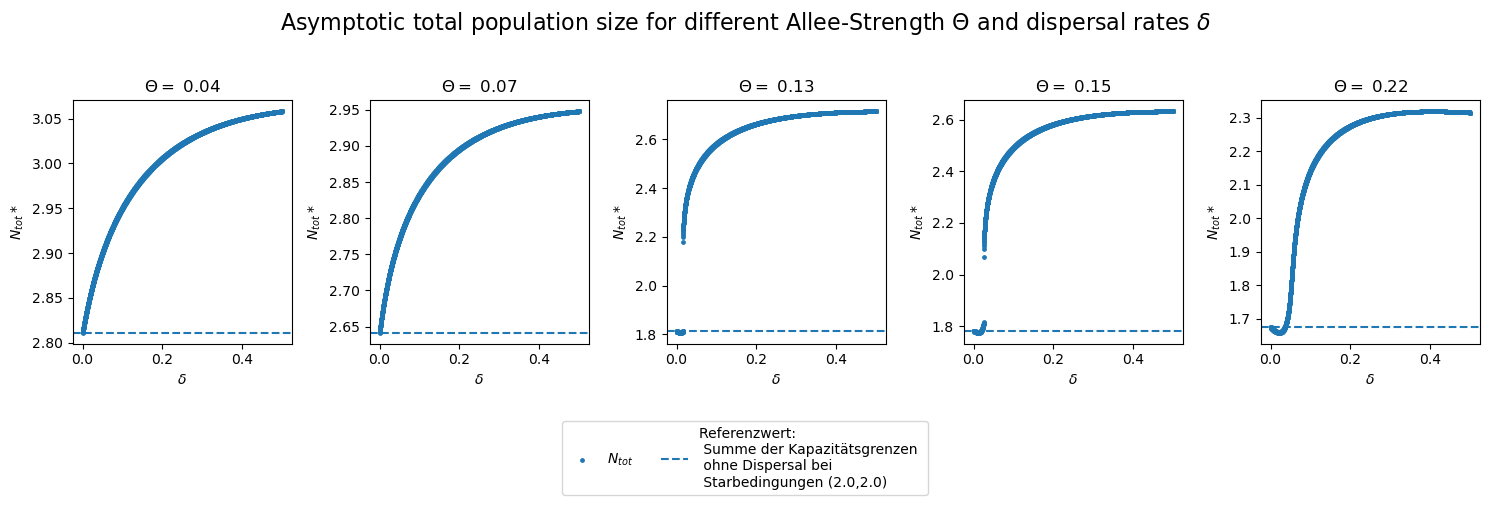

In [29]:
dispersal_rates = np.linspace(0,0.5,5000)
thetas = [ 0.04, 0.07, 0.13, 0.15, 0.22]
fig, axs = plt.subplots(1, len(thetas), figsize = (15,4))
for i,Theta in enumerate(thetas):
    ax = axs[i]
    # Finding relevant Thetas
    params['Theta'] = Theta
    fig, ax = create_N_tot_by_disp(params, dispersal_rates, fig = fig, ax = ax, print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False, shut_plot=False, shut_legend = True, custom_title = '')

middle = np.int16(len(thetas) / 2)
print(middle)

handles, labels = axs[middle].get_legend_handles_labels()

fig.suptitle(f'Asymptotic total population size for different Allee-Strength $\Theta$ and dispersal rates $\delta$', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Put the legend below the subplots
fig.legend(handles, labels, loc='lower center', ncol=len(labels),
           bbox_to_anchor=(0.5, -0.25))

# direct to folder to be saved
path_to_save_figures = os.path.expanduser("~/Desktop/Uni/Projekt Allee-Pit/Report/Plots/N_tot_over_disp/Response_scenarios.png")
fig.savefig(path_to_save_figures, dpi=300)



Wir erhalten also den bereits angenäherten Wert von einem besonderen Wert von $\Theta$, der im Intervall $[0.04285714, 0.04285714]$ liegt. Es scheint, als ob unter diesem Wert die Gleichgewichtspunkte (für ein festes $\Theta$) in Abhängigkeit von $\delta$ sich "stetig" verändern; wir erhalten, dass mit leicht verändertem $\delta$ sich auch nur die Größe der asyptotischen Gesamtpopulation $N_{tot}$ ändert.

Dies scheint sich mit Werten oberhalb dieses Wertes zu ändern. Um den Wert $\delta = 0.0$ herum (auch hier wird jetzt das $\Theta$ festgehalten) ändert sich die langfristige Gesamtpopulationsgröße $N_{tot}$ drastisch.

Im Folgenden soll versucht werden, dies anhand der $\textbf{Nullklinen}$ weiter zu erklären.

## Plot Nullclines


In [17]:
# restart params (to overwrite the changed Theta)
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.1,
    'Theta': 0.38,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])


In [18]:

def compute_nullclines(f, g, params, N_A_range, N_B_range, tol=1e-2, resolution=400):
    """
    Compute nullclines for a 2D discrete system.
    
    Args:
        f, g: Functions defining the discrete system: x_next = f(x, y), y_next = g(x, y)
        x_range, y_range: TUPLES defining domain, e.g. (0, 1.5)
        tol: Tolerance for equality test (|f(x,y)-x| < tol means on x-nullcline)
        resolution: Grid resolution
    
    Returns:
        X, Y: Grid arrays
        x_nullcline_mask, y_nullcline_mask: Boolean arrays for nullcline locations
    """
    N_A_vals = np.linspace(*N_A_range, resolution)
    N_B_vals = np.linspace(*N_B_range, resolution)
    N_A, N_B = np.meshgrid(N_A_vals, N_B_vals)
    
    F = f(N_A, N_B, params)
    G = g(N_A, N_B, params)
    
    x_nullcline_mask = np.abs(F - N_A) < tol
    y_nullcline_mask = np.abs(G - N_B) < tol
    
    return N_A, N_B, x_nullcline_mask, y_nullcline_mask


In [19]:
def plot_nullclines(N_A, N_B, params, x_mask, y_mask, y_min=None, y_max=None, shut_plot = False, plot_traj = False, fig = None, ax = None, custom_title = None, surpress_title = False):
    '''
    TO BE DESCRIBED AND ax. object TO BE USED 
    Parameters:
    N_A: list of values for N_A
    N_B: list of values for N_B
    params: dictionary of parameter
    x_mask: the collection of points for the nullclines 
    y_mask: the collection of points for the nullclines 
    y_max: upper limit of the y-axis, by Default None, so autoscaling will be active
    y_min: lower limit of the y-axis, by Default None, so autoscaling will be active
    fig: Optional, figure object
    ax:  Optional, axis object
    custom_title: if used with passed fig and ax object the title to be customized
    supress_title, bool: if True supresses custom title to be able to have no title at all, by Default False 
    
    '''
    # if no figure or axis object was passed ...
    if fig == None or ax == None:
        # ... create them
        fig, ax = plt.subplots(figsize=(8,8))
        
    # Contour plot    
    cs = ax.contour(N_A, N_B, x_mask, levels=[0.1], colors='red', linewidths=2, linestyles='--')
    # Labeling the contour plots 
    # (cs is the contour object, cs.levels is telling us, how detailledly we shall label, fmt is our string as label and fontsize is fontsize)
    ax.clabel(cs, fmt="$N_A$", fontsize=10)
    
    cs = ax.contour(N_A, N_B, y_mask, levels=[0.5], colors='blue', linewidths=2, linestyles='-')
    # Labeling the contour plots
    ax.clabel(cs,fmt="$N_B$", fontsize=10)
    
    ax.set_xlabel('$N_A$')
    ax.set_ylabel('$N_B$')

    # We check whether we want to display the title
    if not surpress_title:
            
        # If no custom title (usually passed with an fig and ax object) we set this Default title
        if custom_title == None:
            ax.set_title(f'Nullclines of the Discrete System \n disp = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')
        
        # If we did get a custom title...
        else:
            # ... we set it
            ax.set_title(custom_title)
            
    # Plot initial conditions if desired
    if plot_traj:
        ax.scatter(params['N_A'], params['N_B'], s = 10, label="Anfangsbedingungen")
    
    # If desired, limits for the y-axis
    if(y_max != None and y_min != None):
        ax.set_ylim(ymin=y_min, ymax=y_max)

    # OPTION: trajectories
    if (plot_traj):
        # calculate temporal results
        # Returns a twodimensional array (no_timesteps, 2) where [:,0] is N_A and [:,1] is N_B
        results = simulation(params, print_params = False, plot = False, plotting_trajectory = False, plot_instantly = False, plot_trajectory_instantly = False)

        # get the two lists
        traj_N_A = results[:,0]
        traj_N_B = results[:,1]

        # plotting trajectoy
        ax.plot(traj_N_A, traj_N_B, label="Trajectory")
    
    # if we dont calculate the result but have to return a results
    else:
        results = -1
        
    # ax.grid(True)
    ax.legend()
    
    #surpress plotting
    if shut_plot:
        plt.close()
    
    return fig, ax, results
    
    

<>:41: SyntaxWarning: invalid escape sequence '\T'
<>:41: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_178646/232745089.py:41: SyntaxWarning: invalid escape sequence '\T'
  ax.set_title(f'Nullclines of the Discrete System \n disp = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')


## Nullclines for $\Theta = 0.042 < \Theta_{spe}$

In [25]:
# restart params (to overwrite the changed Theta)
# Parameters in Figure 3, disp and Theta changed according to intersting findings
# Disp near 0
params = {}
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.01,
    'Theta': 0.042,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

# direct to folder to be saved
path_to_save_figures = os.path.expanduser("~/Desktop/Grumbach Hilker Allee Pit/Figures for Nullclines with Theta 0,042 below special threshold/")

# EMPTY the directory
files = glob.glob(path_to_save_figures + '*')
for f in files:
    os.remove(f)

disp_rates = np.linspace(0,0.05, 7)
dict_of_figs_by_disp = {}

# Fix a Theta value < Theta special
params['Theta'] = 0.042

print(params)
for disp in disp_rates:
    
    # Update parameter dispersal rate
    params['disp'] = disp
    
    # we compute the nullclines and return all the points in the mask that fulfill the fix point characteristic to a certain tolerance
    # we use the masks to plot the nullclines
    N_A_vals, N_B_vals, x_nullcline_mask, y_nullcline_mask = compute_nullclines(N_A_t_1, N_B_t_1, params, (-0.0,1.5), (-0.0,2.0), tol=1e-4, resolution=2000)
    
    # Here, the actual plotting happens
    fig, ax = plot_nullclines(N_A_vals, N_B_vals, params, x_nullcline_mask, y_nullcline_mask, shut_plot=True)

    # Save figure Object in the dictionary (Theta: fig-object)
    dict_of_figs_by_disp.__setitem__(disp, fig)
    
    # Save fig in new folder
    dataname = path_to_save_figures + str(disp) + '.png'
    fig.savefig(dataname, dpi = 150)
    
print("Done with calculations of nullclines and figs")


{'N_A': 0.1, 'N_B': 0.1, 'disp': 0.01, 'Theta': 0.042, 'r_A': 1.5, 'r_B': 3.5, 'K_A': 1.0, 'K_B': 2.0, 'xi_A': 0.5, 'xi_B': 1.25}


/tmp/ipykernel_10637/506412377.py:26: SyntaxWarning: invalid escape sequence '\T'
  ax.set_title(f'Nullclines of the Discrete System \n disp = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')


UnboundLocalError: cannot access local variable 'results' where it is not associated with a value

In [ ]:
# make the GIF
import imageio.v2 as imageio # aufgrund veralteter Dokumentation mussten wir das in Python 3 so benutzen
with imageio.get_writer(path_to_save_figures + f'Nullclines for Theta = {params['Theta']}.gif', mode='I', duration = 200, loop = 0) as writer:
    for key in dict_of_figs_by_disp.keys():
        # collect all the saved Images
        image = imageio.imread(path_to_save_figures + str(key) + ".png")
        writer.append_data(image)

## Nullclines for $\Theta = 0.043 > \Theta_{spe}$

In [ ]:
# restart params (to overwrite the changed Theta)
# Parameters in Figure 3, disp and Theta changed according to intersting findings
# Disp near 0
params = {}
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.01,
    'Theta': 0.043,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

# direct to folder to be saved
path_to_save_figures = os.path.expanduser("~/Desktop/Grumbach Hilker Allee Pit/Figures for Nullclines with Theta 0,043 above special threshold/")

# EMPTY the directory
files = glob.glob(path_to_save_figures + '*')
for f in files:
    os.remove(f)

disp_rates = np.linspace(0,0.01, 30)
dict_of_figs_by_disp = {}

# Fix a Theta value < Theta special
params['Theta'] = 0.043

print(params)
for disp in disp_rates:
    
    # Update parameter dispersal rate
    params['disp'] = disp
    
    # we compute the nullclines and return all the points in the mask that fulfill the fix point characteristic to a certain tolerance
    # we use the masks to plot the nullclines
    N_A_vals, N_B_vals, x_nullcline_mask, y_nullcline_mask = compute_nullclines(N_A_t_1, N_B_t_1, params, (-0.0,1.5), (-0.0,2.0), tol=1e-4, resolution=2500)
    
    # Here, the actual plotting happens
    fig, ax = plot_nullclines(N_A_vals, N_B_vals, params, x_nullcline_mask, y_nullcline_mask, shut_plot=True)

    # Save figure Object in the dictionary (Theta: fig-object)
    dict_of_figs_by_disp.__setitem__(disp, fig)
    
    # Save fig in new folder
    dataname = path_to_save_figures + str(disp) + '.png'
    fig.savefig(dataname, dpi = 150)
    
print("Done with calculations of nullclines and figs")


In [ ]:
# make the GIF
import imageio.v2 as imageio # aufgrund veralteter Dokumentation mussten wir das in Python 3 so benutzen
with imageio.get_writer(path_to_save_figures + f'Nullclines for Theta = {params['Theta']}.gif', mode='I', duration = 200, loop = 0) as writer:
    for key in dict_of_figs_by_disp.keys():
        # collect all the saved Images
        image = imageio.imread(path_to_save_figures + str(key) + ".png")
        writer.append_data(image)

# Next steps
- maintain Low/Low sysmmetric initial conditions (i.e $(0.1,0.1)$ or $(0.5,0.5)$)
- repeat plotting nullclines for a higher value of $\Theta$ ...
- ... and a small range of $\delta$, where multistability is occuring $\rightarrow $ we obtain a GIF
- plot nullclines, initial conditions and trajectories together
- explain striking results ecologically

## Plotting Nullclines for a higher value of $\Theta$


We use the parameters given in Figure 3 again and only want to change $\Theta$ from $\Theta = 0.042...$ to somewhat higher in value.

We will obtain such a value from the following GIF:

In [35]:
from IPython.display import HTML

HTML("""
<img src="./Figures%20for%20total%20population%20size%20against%20dispersal%20rates%20Low%20Low/N_tot_over_disp_N_A_0.1_N_B_0.1.gif" loop autoplay>
""")

According to the results, we will continue by setting $\Theta = 0.15$ to ensure, that we have multi-stability and a higher value of $\Theta$.

In [18]:
params = {}
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.01,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

path_to_save_figures = os.path.expanduser("~/Desktop/Grumbach Hilker Allee Pit/Figures_for_Nullclines_with_Theta_0,15/")

# EMPTY the directory
files = glob.glob(path_to_save_figures + '*')
for f in files:
    os.remove(f)

# in the beginning we want a finer resolution of nullclines and trajectoris
disp_rates_one = np.linspace(0,0.1, 40)

# and then continue a little faster
disp_rates_two = np.linspace(0.11, 0.5,15)

# merge the two disp_rates_arrays two a whole
disp_rates = np.concatenate((disp_rates_one, disp_rates_two))

dict_of_figs_by_disp = {}

# Here, we will save the trajectories
dict_of_trajectories = {}

print(params)
for i,disp in enumerate(disp_rates):
    # progress bar
    print(f" progress: {np.round((i / len(disp_rates)*100))} %, disp = {disp}")
    
    # Update parameter dispersal rate
    params['disp'] = disp
    
    # we compute the nullclines and return all the points in the mask that fulfill the fix point characteristic to a certain tolerance
    # we use the masks to plot the nullclines
    N_A_vals, N_B_vals, x_nullcline_mask, y_nullcline_mask = compute_nullclines(N_A_t_1, N_B_t_1, params, (-0.0,1.5), (-0.0,2.0), tol=1e-4, resolution=2500)
    
    # Here, the actual plotting happens
    fig, ax = plot_nullclines(N_A_vals, N_B_vals, params, x_nullcline_mask, y_nullcline_mask, shut_plot=True, plot_traj = True)

    # Save figure Object in the dictionary (Theta: fig-object)
    dict_of_figs_by_disp.__setitem__(disp, fig)
    
    # Save fig in new folder
    dataname = path_to_save_figures + str(disp) + '.png'
    fig.savefig(dataname, dpi = 150)
    
print("Done with calculations of nullclines and figs")

{'N_A': 0.1, 'N_B': 0.1, 'disp': 0.01, 'Theta': 0.15, 'r_A': 1.5, 'r_B': 3.5, 'K_A': 1.0, 'K_B': 2.0, 'xi_A': 0.5, 'xi_B': 1.25}
 progress: 0.0 %, disp = 0.0
 progress: 2.0 %, disp = 0.002564102564102564
 progress: 4.0 %, disp = 0.005128205128205128
 progress: 5.0 %, disp = 0.007692307692307693
 progress: 7.0 %, disp = 0.010256410256410256
 progress: 9.0 %, disp = 0.01282051282051282
 progress: 11.0 %, disp = 0.015384615384615385
 progress: 13.0 %, disp = 0.017948717948717947
 progress: 15.0 %, disp = 0.020512820512820513
 progress: 16.0 %, disp = 0.023076923076923078
 progress: 18.0 %, disp = 0.02564102564102564
 progress: 20.0 %, disp = 0.028205128205128206
 progress: 22.0 %, disp = 0.03076923076923077
 progress: 24.0 %, disp = 0.03333333333333333
 progress: 25.0 %, disp = 0.035897435897435895
 progress: 27.0 %, disp = 0.038461538461538464
 progress: 29.0 %, disp = 0.041025641025641026
 progress: 31.0 %, disp = 0.04358974358974359
 progress: 33.0 %, disp = 0.046153846153846156
 progr

In [19]:
params['Theta'] = 0.15
# make the GIF
import imageio.v2 as imageio # aufgrund veralteter Dokumentation mussten wir das in Python 3 so benutzen
with imageio.get_writer(path_to_save_figures + f'Nullclines_for_Theta_{params['Theta']}.gif', mode='I', duration = 200, loop = 0) as writer:
    for key in dict_of_figs_by_disp.keys():
        # collect all the saved Images
        image = imageio.imread(path_to_save_figures + str(key) + ".png")
        writer.append_data(image)

## Results

In [20]:
from IPython.display import HTML

HTML("""
<img src="./Figures_for_Nullclines_with_Theta_0,15/Nullclines_for_Theta_0.15.gif" width="750" height="750" loop autoplay>
""")

- Drei Abbildungen als Standbilder aus dem GIF extrahieren
- Beschreibung
- Erkenntnisse beschreiben (Einleitung: Thematik, Ökologische Hintergründe (Fragmentierung, Allee-Effekt, ...), warum veränderte Bedingungen (Störungen), was sind die Konsequenzen)
- Erkenntnisse präzise erklären und darstellen
- Mechanismus der drei Attraktoren erklären und beschreiben
- Lieber sauber einen Fall
- Auf Englisch
- Bullet Point List -> Line of Argumentation
- Digitaler Anhang (myShare Link bspw.)

Wir sehen in der oberen Abbildung die numerisch errechneten Nullklinen des betrachteten diskreten Systems (Rot die Nullklinen von $N_A$, Blau die Nullklinen von $N_B$) im Phasenraum unter Veränderungen der Dispersal-Rate $\delta \in [0,0,5]$ unter einem konstanten Wert der Allee-Stärke $\Theta = 0.15$. Die restlichen Parameter sind gewählt (TABELLE DER PARAMETER EINFÜGEN). In Grau-Blau sehen wir außerdem die zu den Parametern gehörige Trajektorie eines Simulationsdurchlaufes mit $500$ Zeitschritten. Es wird davon ausgegangen, dass das System auf diese Weise sich einem Langzeitverhalten entsprechend verhält. Dabei sind die Anfangsbedingungen mit $\begin{pmatrix}N_A & N_B \end{pmatrix} = \begin{pmatrix}0,1 & 0,1 \end{pmatrix}$ konstant.
Schnittpunkte der Nullkline kennzeichnen Gleichgewichtspunkte des Systems. Die Nullkline ändern sich jedoch mit der Veränderung des $\delta$ und damit auch die Lage der Gleichgewichtspunkte im Phasenraum. Bestätigt wird dies durch die Trajektorie, die immer in einem der Schnittpunke der Nullklinen endet.
Im Speziellen ergeben sich zwei Stabilitätspunkte, auf die nun genauer eingegangen werden soll.

Wir erkennen für geringe Werte von $\delta$, dass sich ein Schnittpunkt nahe $\begin{pmatrix}N_A & N_B \end{pmatrix} = \begin{pmatrix}0 & 1,75 \end{pmatrix}$ ergibt.Die Population, die eine geringere 



- $\delta = 0.01$,$ \delta = 0.1$, $\delta = 0.35$
- $\Theta = 0.15$
- $N_A = 0.1$
- $N_B = 0.1$
- $r_A = 1.5$
- $r_B = 3.5$
- $K_A = 1.0$
- $K_B = 2.0$
Wir wollen hierfür jetzt jeweils den Sphase Space mit Nullklinen und Trajketorie plus den zeitlichen Verlauf erhalten ud miteinander vergleichen. Dabei soll insbesondere der Vergleich zu den bisherigen Ergebnissen im Bezug auf Allee-Pit, Rescue-effect oder detrimental effects getan werden.


<>:60: SyntaxWarning: invalid escape sequence '\d'
<>:60: SyntaxWarning: invalid escape sequence '\T'
<>:95: SyntaxWarning: invalid escape sequence '\d'
<>:95: SyntaxWarning: invalid escape sequence '\T'
<>:60: SyntaxWarning: invalid escape sequence '\d'
<>:60: SyntaxWarning: invalid escape sequence '\T'
<>:95: SyntaxWarning: invalid escape sequence '\d'
<>:95: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_162255/2058991606.py:60: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Nullclines of the Discrete System \n $\delta$ = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')
/tmp/ipykernel_162255/2058991606.py:60: SyntaxWarning: invalid escape sequence '\T'
  ax.set_title(f'Nullclines of the Discrete System \n $\delta$ = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')
/tmp/ipykernel_162255/2058991606.py:95: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Temporal Behaviour of the \n populations $N_A$ and $N_B$ \n $\d

 progress: 0.0 %, disp = 0.01
 progress: 20.0 %, disp = 0.05
 progress: 40.0 %, disp = 0.1
 progress: 60.0 %, disp = 0.27
 progress: 80.0 %, disp = 0.31


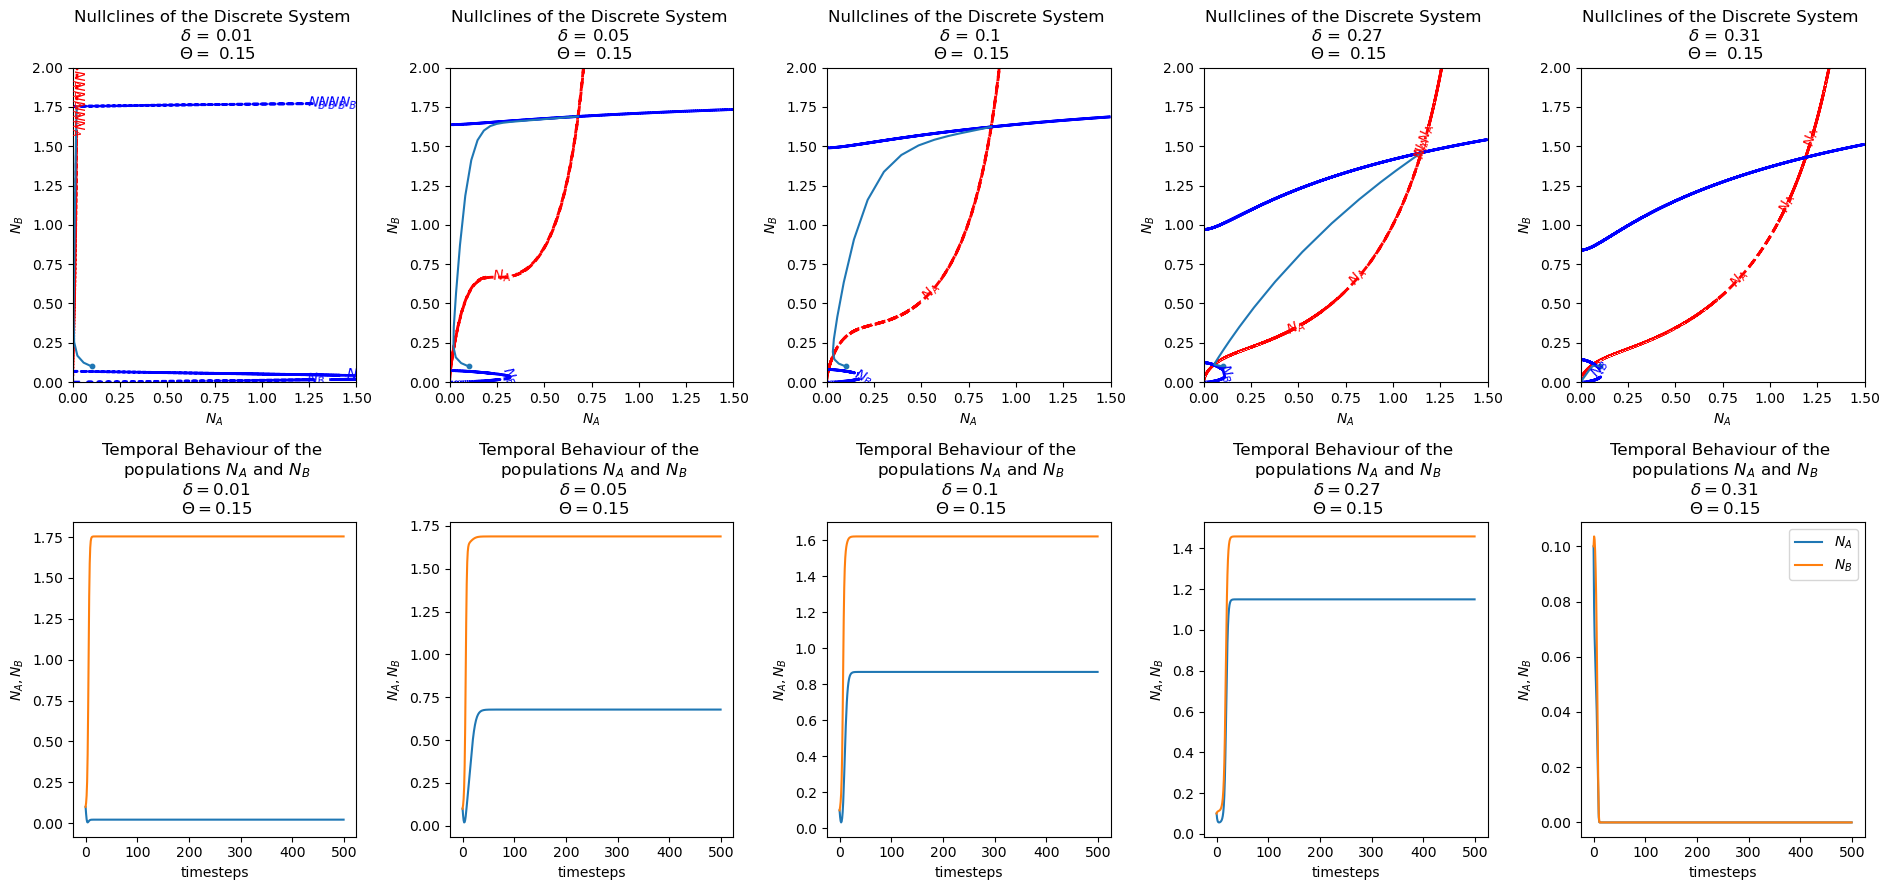

In [68]:
# Update directory of Saving
path_to_save = os.path.expanduser('~/Desktop/Uni/Projekt Allee-Pit/Report/Plots/Multiplot nullclines and temporal behaviour/')

# EMPTY the directory
files = glob.glob(path_to_save + '*')
for f in files:
    os.remove(f)
    
# Update parameter
params = {}
params = {
    'N_A': 0.1,
    'N_B': 0.1,
    'disp': 0.01,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}

# calculate xi
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

# our dispersal rates of interest
disp_rates = [0.01, 0.05, 0.1, 0.27, 0.31]

# 2 x len(disp_rates) subplots (for each of the three dispersal rates temporal dynamics and sphase spaces with nullclines and trajectory)
fig, axs = plt.subplots(2,len(disp_rates), figsize=(19,9))
                        
### SPHASE SPACE ##########
for i,disp in enumerate(disp_rates):
    # progress bar
    print(f" progress: {np.round((i / len(disp_rates)*100))} %, disp = {disp}")
    
    # Update parameter dispersal rate
    params['disp'] = disp

    # Get the i-th plot in the first row to display the Nullclines
    ax = axs[0][i]
    
    # we compute the nullclines and return all the points in the mask that fulfill the fix point characteristic to a certain tolerance
    # we use the masks to plot the nullclines
    # Here WE ALSO GET THE TEMPORAL BEHAVIOUR
    N_A_vals, N_B_vals, x_nullcline_mask, y_nullcline_mask = compute_nullclines(N_A_t_1, N_B_t_1, params, (-0.0,1.5), (-0.0,2.0), tol=1e-4, resolution=4000)
    
    # PLOTTING NULLCLINES + TRAJECTORY IN MULTIPLOT
    cs = ax.contour(N_A_vals, N_B_vals, x_nullcline_mask, levels=[0.1], colors='red', linewidths=2, linestyles='--')
    # Labeling the contour plots 
    # (cs is the contour object, cs.levels is telling us, how detailledly we shall label, fmt is our string as label and fontsize is fontsize)
    ax.clabel(cs, fmt="$N_A$", fontsize=10)
    
    cs = ax.contour(N_A_vals, N_B_vals, y_nullcline_mask, levels=[0.5], colors='blue', linewidths=2, linestyles='-')
    # Labeling the contour plots
    ax.clabel(cs,fmt="$N_B$", fontsize=10)
    
    ax.set_xlabel('$N_A$')
    ax.set_ylabel('$N_B$')
    ax.set_title(f'Nullclines of the Discrete System \n $\delta$ = {np.round(params['disp'], 3)} \n $\Theta = $ {params['Theta']}')
    ax.scatter(params['N_A'], params['N_B'], s = 10, label="Anfangsbedingungen")
    
    # If desired, limits for the y-axis
    # if(y_max != None and y_min != None):
      #  ax.set_ylim(ymin=y_min, ymax=y_max)

    # TRAJECTORIES 
    
    # calculate temporal results
    # Returns a twodimensional array (no_timesteps, 2) where [:,0] is N_A and [:,1] is N_B
    results = simulation(params, print_params = False, plot = False, plotting_trajectory = False, plot_instantly = False, plot_trajectory_instantly = False)

    # get the two lists
    traj_N_A = results[:,0]
    traj_N_B = results[:,1]

    # plotting trajectoy
    ax.plot(traj_N_A, traj_N_B, label="Trajectory")
    
    # ax.grid(True)
    # ax.legend()
    
    
    ### TEMPORAL behaviour ####
    # Now we plot lower row
    ax = axs[1][i]
    N_A_vals = results[:,0]
    N_B_vals = results[:,1]
    
    ax = axs[1][i]
    ax.plot(np.arange(0,len(N_A_vals)),N_A_vals, label="$N_A$")
    ax.plot(np.arange(0,len(N_B_vals)),N_B_vals, label="$N_B$")
    ax.set_xlabel('timesteps')
    ax.set_ylabel('$N_A, N_B$')
    ax.set_title(f'Temporal Behaviour of the \n populations $N_A$ and $N_B$ \n $\delta = ${params['disp']} \n $\Theta = {params['Theta']}$')
    
# Save fig in new folder
fig.tight_layout()
plt.legend()
plt.show()
dataname = path_to_save + "Multiplot on dynamics under disturbance of the initial conditions and various dispersal rates"
fig.savefig(dataname, dpi = 150)

## First Results: Temporal Dynamics + Trajectories with $\delta \in [0.0, 0.035]$ and $\Theta = 0.13$
The interval for $\delta$ was obtained by exploring strikening values of the dispersal rate, when asymptotical total population was plotted against dispersal rate. By varying $\Theta$ a $\Theta = 0.13$ was chosen in order to examine the effects occuring here (regime shift) in more detail. Initital conditions were fixed in a "Low-Low" Scenario meaning $(N_A, N_B) = (0.05, 0.05)$.


We can see, that the asymptotic total population size is only determined by the smaller patches population size. Population $N_B$ is growing steadily and without greater shifts in long-time behaviour as the Allee-Strength $\delta$ is varied. The smaller population  $N_A$ however is only able to reach its capacity when the dispersal rate reaches a certain value. For values above this crucial $\delta$ we have the already described rescue-effect(?).

- To be covered: Allee-Pit and which 

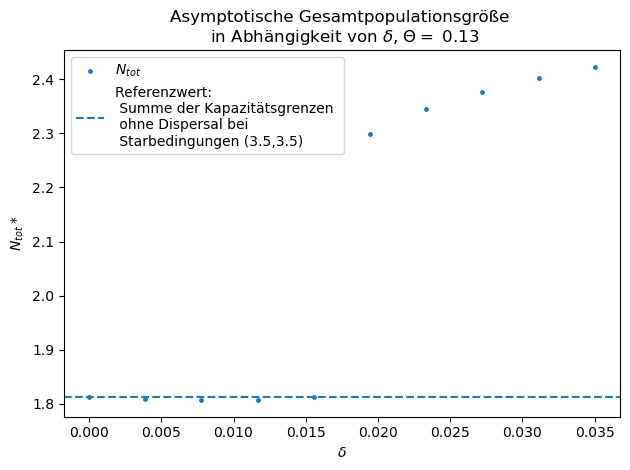

In [28]:
dispersal_rates = np.linspace(0,0.035,10)
# thetas = [0.05, 0.165, 0.33, 0.345,0.371, 0.48, 0.7]
thetas = [0.13]
for Theta in thetas:
    # create all seven Scenarios
    params['Theta'] = Theta
    create_N_tot_by_disp(params,dispersal_rates,print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False)

## Low, Low - (0.05, 0.15) "Strong" population slightly higher

In [32]:
# Parameters in Figure 3
params = {
    'N_A': 0.05,
    'N_B': 0.15,
    'disp': 0.0,
    'Theta': 0.38,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

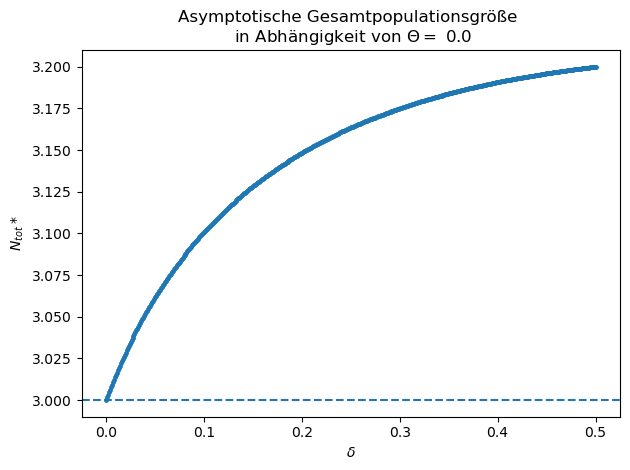

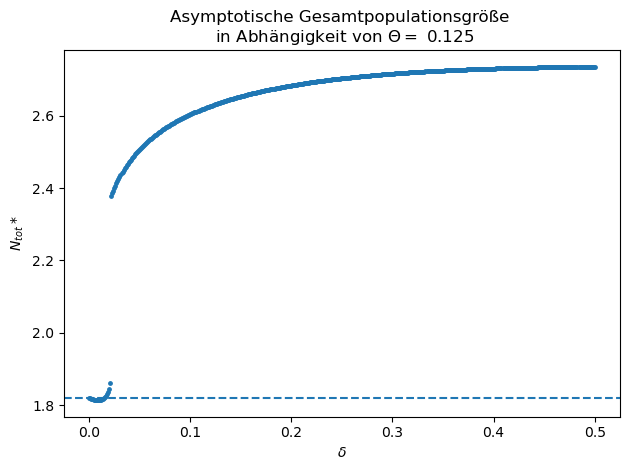

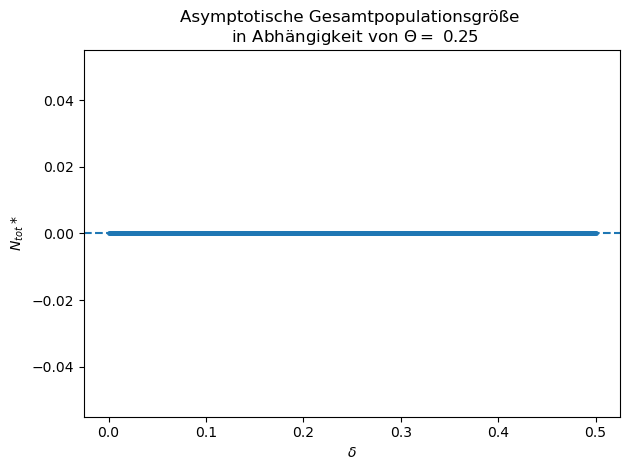

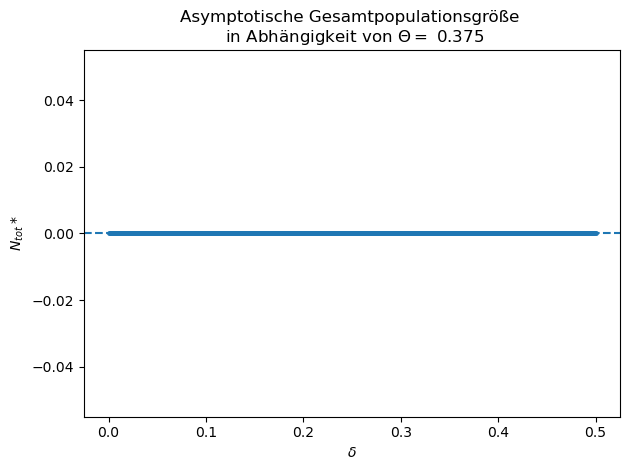

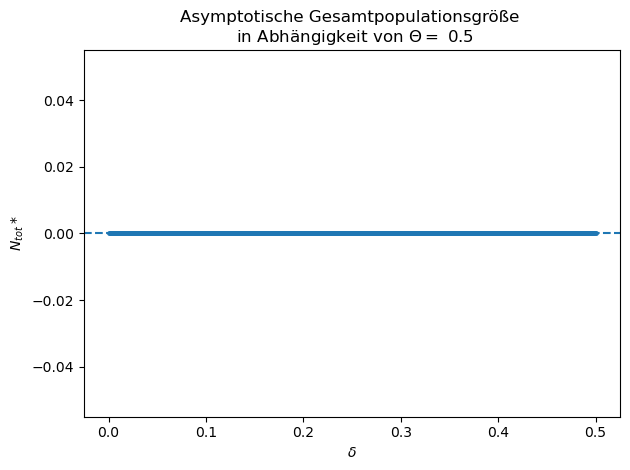

In [20]:
dispersal_rates = np.linspace(0,0.5,500)
# thetas = [0.05, 0.165, 0.33, 0.345,0.371, 0.48, 0.7]
thetas = np.linspace(0,0.5,5)
for Theta in thetas:
    # create all seven Scenarios
    params['Theta'] = Theta
    create_N_tot_by_disp(params,dispersal_rates,print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False)

# Low-High (0.1, 0.8)

In [34]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.0,
    'Theta': 0.38,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])


In [19]:
dispersal_rates = np.linspace(0,0.5,5000)
# thetas = [0.05, 0.165, 0.33, 0.345,0.371, 0.48, 0.7]
thetas = np.linspace(0,0.5,50)
for Theta in thetas:
    # create all seven Scenarios
    params['Theta'] = Theta
    create_N_tot_by_disp(params,dispersal_rates,print_params = False, plotting_temporal_behaviour = False, plot_trajectory = False, shut_plot=True)

# Creation of basin of attraction
We now want to create basins of attraction for different parameter scenarios.
As the initial conditions change, other equilibria than the coexistence equilibrium could be reached. 
Therefore a selection of basins of attraction of different values for dispersal rate and Allee-strength will be created to give an overview of how intial conditions shape long term behaviour, which is numerically approximated by the 500th iteration of the numeric model.
Note, that dispersal rates and Allee-strength are determining the form of the nullclines and therefore the coordinates of equilibria in the phase space. 
Our parameter set (derived from Grumbach and Hilker, 2024):

In [21]:
def create_and_plot_basin_of_attraction(params:dict, res:int, res_traj:int, fig = None, ax = None, upper_bound_A = 3.5, upper_bound_B = 3.0, alpha = 0.4, plot_traj=False, display_legend = False, show_legend = False):
    '''
    Calculates and plots a basin of attraction for a given set of parameters numerically. Optionally displays the trajectories that are calculated 'on the way'.

    DESCRIPTION
    Basically, the method divides the given range for A [0, upper_bound_A] and B [0, upper_bound_B] in res values. 
    So np.linspace(0, upper_bound_A, res) is used. This gives us a set of initial conditions equally distributed across the phase space in the given range.
    Then, for every combination of initial we calculate the trajectories and save the last value of 500 iterations as a approximation for the asymptotic value.
    So we obtain res * res trajectories and numerical asymptotic values.
    We round these asymptotic values up to a certain accuracy (e.g. three decimals) and extract the unique tuples. Note, that these are usually like three or five of those equilibria.
    Using these tuples as an approximation for our approached equilibria we find the closest equilibrium for all asymptotic values given a certain initial condition (and parameter set).
    We then create another res*res array to map a index (the index of what equilibrium is reached closest by a trajectory, measured in the euclidean distance) to the inital condition.
    And finally we plot these indices and the found equilibria. 
    Additionally, we can plot the trajectories that were produced while calculating the numeric results. 
    As we do want to have a detailed raster for the basin we reduce the number of plotted arrays by a constant factor (realized by res_traj) to reduce computational load. 

    PARAMETERS
    - params, dict: dictionary with the parameters. Needs to contain N_A, N_B, disp, Theta, r_A, r_B, K_A, K_B
    - res: defines how many values are considered between 0 and upper_bound_X. Basically defines the basins raster density
    - res_traj: defines how many of the res*res trajectoris are plotted actually. If res_traj = 5, every fifth trajectory horizontally and vertically is plotted.
    - upper_bound_A, upper_bound_B, float, float: defines the upper bounds of the basin. Lower bound is hardcoded to be 0.0
    - alpha, float: defines the opacity for the trajectories
    - plot_traj, bool: switch on and off trajectory plotting, by Default False
    '''
    # Update parameter
    params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
    params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])
    
    if fig == None or ax == None:
        # plot
        fig, ax = plt.subplots()
    
    # The resolution for the investigation of phase space. Determines, how many values will be respected on the range for N_A and N_B
    res = res
    
    # upper range end for N_A or N_B
    top_end_A = upper_bound_A
    top_end_B = upper_bound_B
    
    # create a range, that will be investigated in the phase space
    N_A = np.linspace(0,top_end_A, res)
    N_B = np.linspace(0,top_end_A, res)
    
    # make two-dimensional array for saving the asymptotic value as a two dimensional vector
    asymptotic_values = np.zeros((len(N_A), len(N_B)), dtype= object)
    # Plot by using imshow
    # make data
    X, Y = np.meshgrid(N_A, N_B);
    
    # 1. for every initial condition we calculate and save the last value [N_A_i, N_B_i] -> [N_A*_i, N_B*_i]
    for i, initial_A in enumerate(N_A):
        for j, initial_B in enumerate(N_B):
            # Update initial conditions in params
            params['N_A'] = initial_A
            params['N_B'] = initial_B
            
            # calculate temporal results
            # Returns a twodimensional array (no_timesteps, 2) where [:,0] is N_A and [:,1] is N_B
            results = simulation(params, print_params = False, plot = False, plotting_trajectory = False, plot_instantly = False, plot_trajectory_instantly = False)
            # print(f'i: {i}, j: {j}')
            # Plot trajectory and only plot every res_traj-th trajectory to obtain detailed basin but not a crowded graphic
            
            if plot_traj and i % res_traj == 0 and j % res_traj == 0:
                ax.scatter(results[0][0], results[0][1], s = 5, alpha = alpha, color='Gray')
                ax.plot(results[:,0], results[:,1], alpha = alpha, color='Grey')
            
            # Save asymptotic values
            asymptotic_value_A = results[-1,0]
            asymptotic_value_B = results[-1,1]
    
            # append asympt. values in the array 
            asymptotic_values[j][i] = (asymptotic_value_A, asymptotic_value_B)
    
    # 2. we get all the unique values up to a certain accuracy with tolerance to be defined -> list of unique!two-dimensional vectors [[N_A*_1, N_B*_1], [N_A*_2, N_B*_2],[N_A*_3, N_B*_3]]
    number_of_decimals = 3
    
    # flatten copy of an array 
    copy_asymptotic_values = asymptotic_values.copy()
    
    # reshape the array to a flattened
    flattened = copy_asymptotic_values.reshape(-1,)
    
    # round
    for i in range(len(flattened)):
        flattened[i] = tuple(np.round(flattened[i], number_of_decimals))
    
    # get the unique values
    equilibria = np.unique(flattened)
    
    # 3. we label each [N_A*_i, N_B*_i] in our list according to the nearest distance of one of our unique two-dimensional vectors by declaring a natural number
    #   -> [N_A_i, N_B_i] |-> 0,1,2,3,
    
    # make two-dimensional array for saving the index related to the nearest equilibrium
    nearest_equi = np.zeros((len(N_A), len(N_B)), dtype= object)
    
    for i, initial_A in enumerate(N_A):
        for j, initial_B in enumerate(N_B):
            # get the asymptotic value, we want to check for
            asymptotic_value = asymptotic_values[j][i]
            
            # start difference is set to a large value
            diff = 100

            # Here we will save the index of the closest equilibrium
            index_of_nearest_equilibrium = -1
            
            for k,equi_tuple in enumerate(equilibria):
                
                # calculate euclidean distance between asymptotic_value and equi_tuple
                euclidean_difference = np.linalg.norm(np.array(asymptotic_value)-np.array(equi_tuple)) 
                
                # if we are nearer than we have been to the last nearest equilibrium, save this closer distance
                if euclidean_difference < diff:
                    # Update smallest distance
                    diff = euclidean_difference
    
                    # We update the index for the equilibrium that is nearest
                    index_of_nearest_equilibrium = k
    
            # Now we set the index of the equilibrium that is nearest
            nearest_equi[j][i] = index_of_nearest_equilibrium
    
    # plot the basin of attraction
    nearest_equi = nearest_equi.astype(float)
    ax.pcolormesh(X,Y,nearest_equi, label='Basins of Attraction')

    # Plot Nullclines
    
    # we compute the nullclines and return all the points in the mask that fulfill the fix point characteristic to a certain tolerance
    # we use the masks to plot the nullclines
    N_A_vals, N_B_vals, x_nullcline_mask, y_nullcline_mask = compute_nullclines(N_A_t_1, N_B_t_1, params, (0.0, upper_bound_A), (0.0,upper_bound_B), tol=1e-4, resolution=2500)
    
    # Here, the actual plotting happens
    fig, ax, _ = plot_nullclines(N_A = N_A_vals, N_B = N_B_vals, params = params, x_mask = x_nullcline_mask, y_mask=y_nullcline_mask, shut_plot=False, plot_traj = False, fig = fig, ax = ax, surpress_title = True)
    # N_A, N_B, params, x_mask, y_mask, y_min=None, y_max=None, shut_plot = False, plot_traj = False, fig = None, ax = None, custom_title = None, surpress_title = False):
    
    # Plot all the found approximated equilibria
    for equi in equilibria:
        if equi[0] < upper_bound_A and equi[1] < upper_bound_B:
            ax.scatter(equi[0], equi[1], s = 20, alpha = 1.0, color='Green', label=f'Equilibrium: {equi}')
    
    # Plot initial condintions (0.1, 0.1)
    ax.scatter(0.1,0.1, s = 20, color='Pink', label = '(0.1,0.1)')
        
    # 
    if display_legend:
        plt.legend()
    if show_legend:
        plt.show()

    return fig, ax
    


/tmp/ipykernel_162255/2004894631.py:73: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$N_A$', ylabel='$N_B$'>)

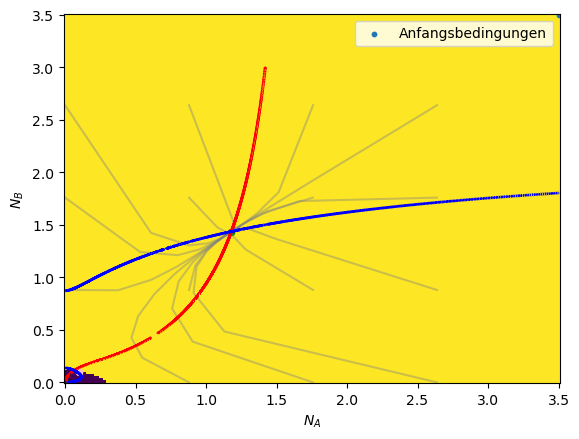

In [75]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.3,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
create_and_plot_basin_of_attraction(params = params, res = 200, res_traj = 50, upper_bound_A = 3.5, upper_bound_B = 3.0, alpha = 0.4, plot_traj = True)

In [ ]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
create_and_plot_basin_of_attraction(params = params, res = 1000, res_traj = 200, upper_bound_A = 3.5, upper_bound_B = 3.0, alpha = 0.4, plot_traj = True)

0.25


/tmp/ipykernel_93079/2004894631.py:73: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_93079/1449750320.py:140: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


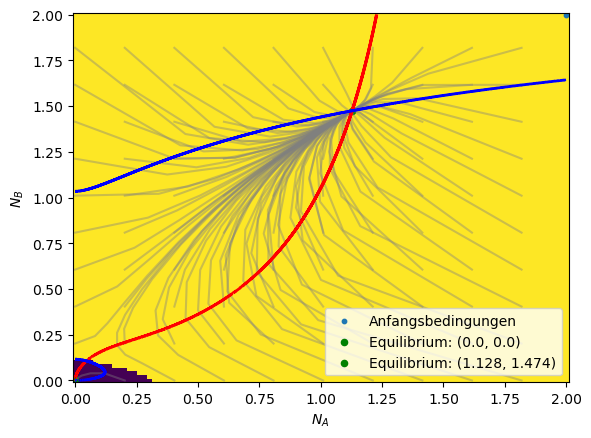

0.2611111111111111


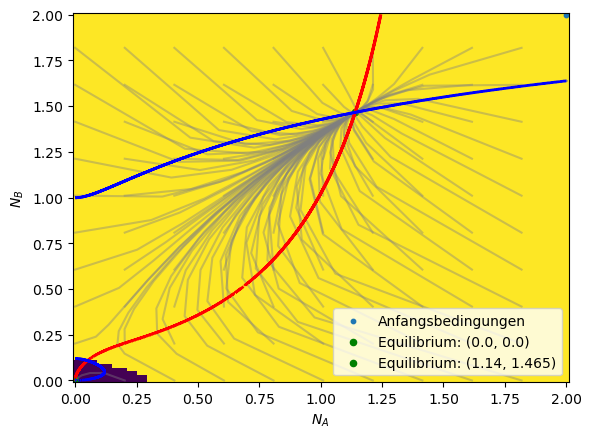

0.2722222222222222


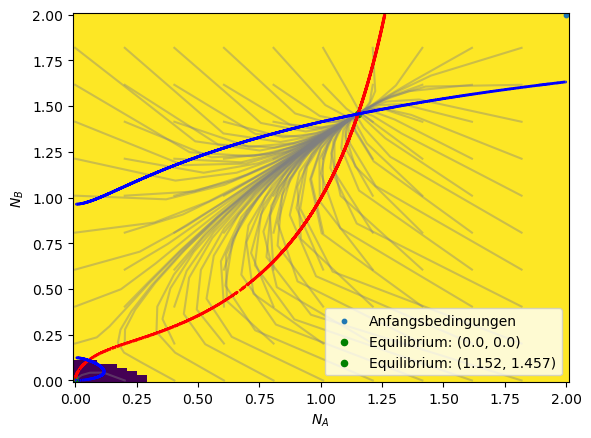

0.2833333333333333


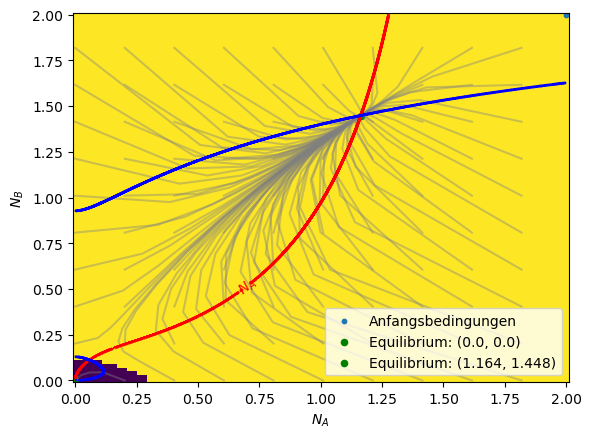

0.29444444444444445


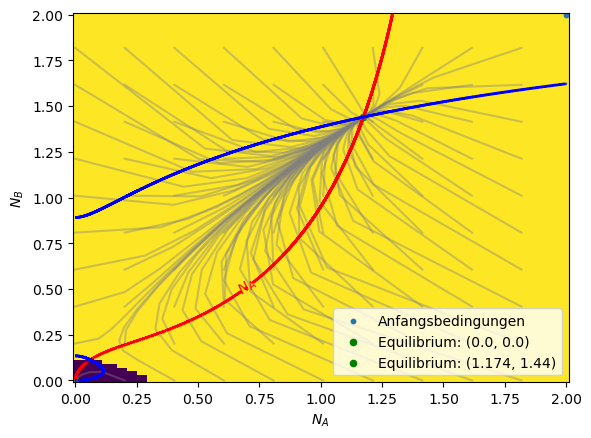

0.3055555555555555


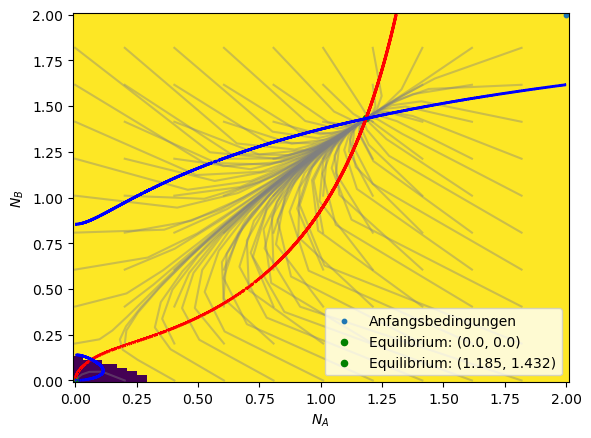

0.31666666666666665


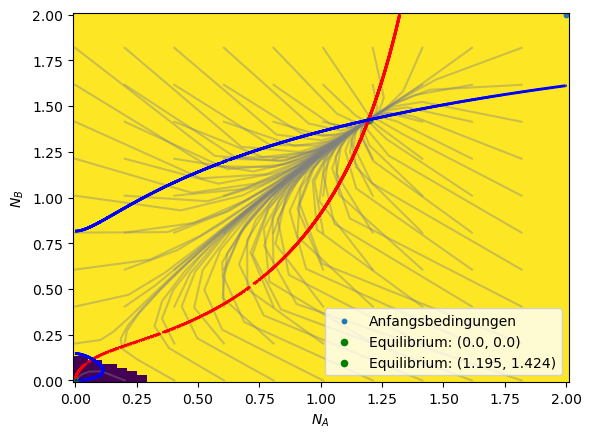

0.3277777777777777


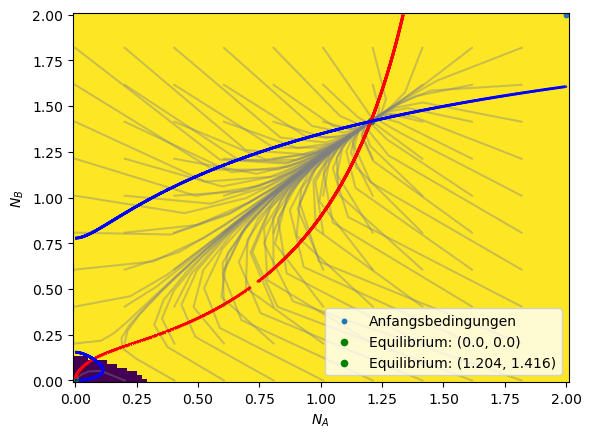

0.33888888888888885


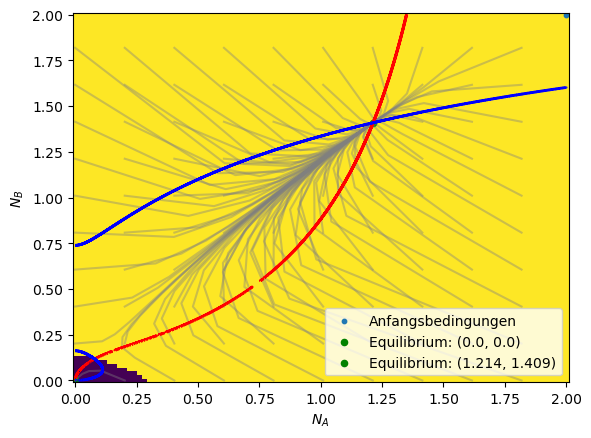

0.35


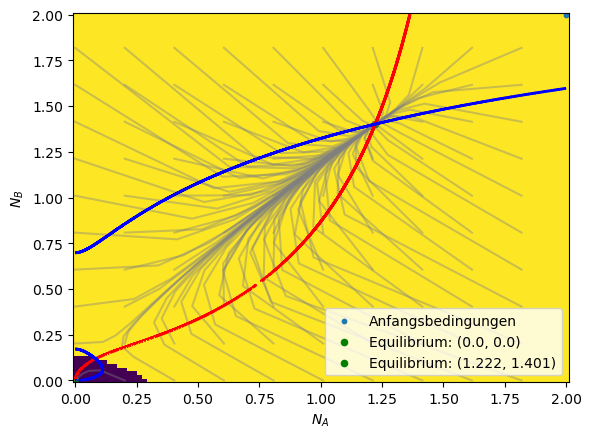

In [30]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
disp_rates = np.linspace(0.25,0.35,5)
fig, axs = plt.subplots

for disp in disp_rates:
    print(disp)
    params['disp'] = disp
    create_and_plot_basin_of_attraction(params = params, res = 100, res_traj = 10, upper_bound_A = 2.0, upper_bound_B = 2.0, alpha = 0.4, plot_traj = True)

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_178646/838925325.py:22: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'$\delta = {disp}$')
/tmp/ipykernel_178646/838925325.py:29: SyntaxWarning: invalid escape sequence '\d'
  fig.suptitle(f'Nullclines and basin of attraction for different dispersal rates $\delta$', fontsize = 16)


0.25


/tmp/ipykernel_178646/232745089.py:74: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_178646/232745089.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


0.27
0.29
0.31
0.33
2


/tmp/ipykernel_178646/838925325.py:27: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = axs[middle].get_legend_handles_labels()


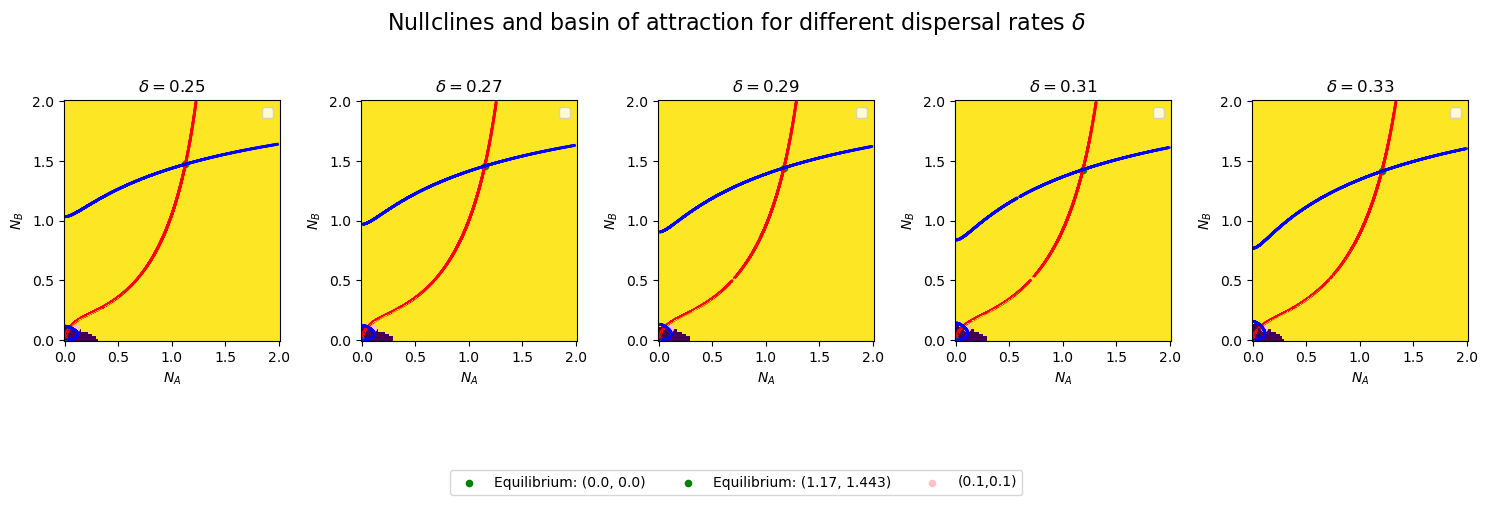

In [24]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}


disp_rates = [ 0.25, 0.27, 0.29, 0.31, 0.33]
fig, axs = plt.subplots(1, len(disp_rates), figsize = (15,4))
for i,disp in enumerate(disp_rates):
    ax = axs[i]
    # Finding relevant Thetas
    print(disp)
    params['disp'] = disp
    fig, ax = create_and_plot_basin_of_attraction(params = params, fig = fig, ax = ax, res = 100, res_traj = 10, upper_bound_A = 2.0, upper_bound_B = 2.0, alpha = 0.4, plot_traj = False)
    ax.set_title(f'$\delta = {disp}$')
    
middle = np.int16(len(thetas) / 2)
print(middle)

handles, labels = axs[middle].get_legend_handles_labels()

fig.suptitle(f'Nullclines and basin of attraction for different dispersal rates $\delta$', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Put the legend below the subplots
fig.legend(handles, labels, loc='lower center', ncol=len(labels),
           bbox_to_anchor=(0.5, -0.25))
# direct to folder to be saved
path_to_save_figures = os.path.expanduser("~/Desktop/Uni/Projekt Allee-Pit/Report/Plots/Basins.png")
fig.savefig(path_to_save_figures, dpi=300)


<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_178646/174187742.py:22: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'$\delta = {disp}$')
/tmp/ipykernel_178646/174187742.py:28: SyntaxWarning: invalid escape sequence '\d'
  fig.suptitle(f'Nullclines and basin of attraction for different dispersal rates $\delta$', fontsize = 16)


0.25


/tmp/ipykernel_178646/232745089.py:74: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_178646/232745089.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


0.27
0.29
0.31
0.33
2


/tmp/ipykernel_178646/174187742.py:26: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = axs[middle].get_legend_handles_labels()


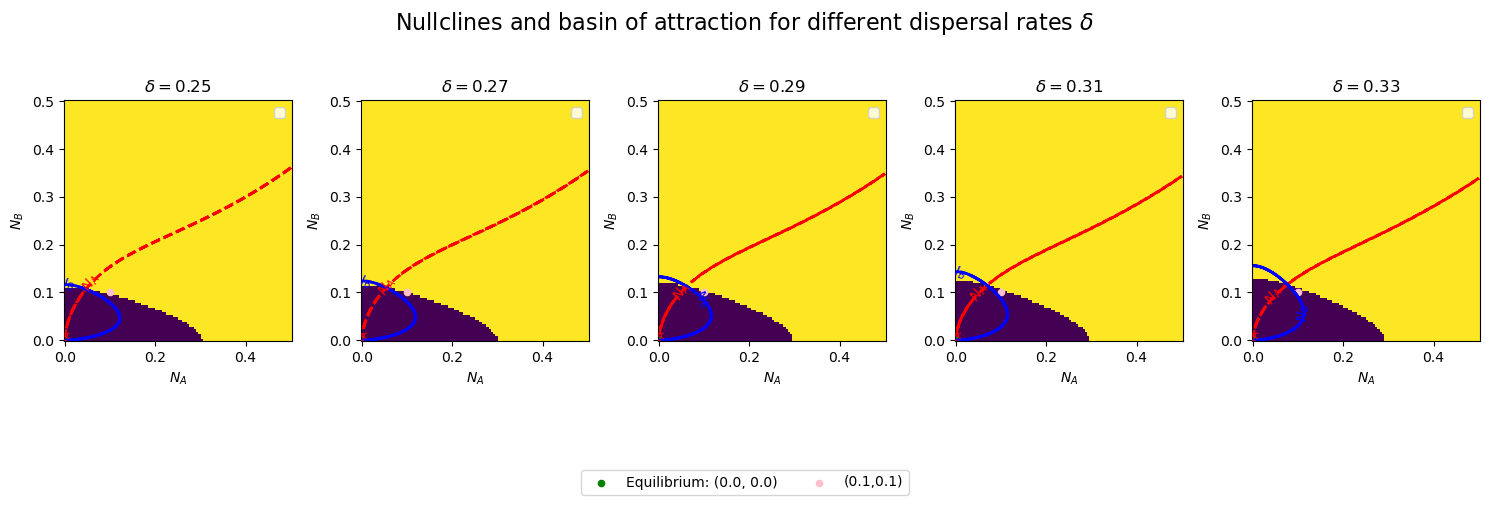

In [23]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}


disp_rates = [ 0.25, 0.27, 0.29, 0.31, 0.33]
fig, axs = plt.subplots(1, len(disp_rates), figsize = (15,4))
for i,disp in enumerate(disp_rates):
    ax = axs[i]
    # Finding relevant Thetas
    print(disp)
    params['disp'] = disp
    fig, ax = create_and_plot_basin_of_attraction(params = params, fig = fig, ax = ax, res = 100, res_traj = 100, upper_bound_A = 0.5, upper_bound_B = 0.5, alpha = 0.4, plot_traj = False)
    ax.set_title(f'$\delta = {disp}$')
middle = np.int16(len(thetas) / 2)
print(middle)

handles, labels = axs[middle].get_legend_handles_labels()

fig.suptitle(f'Nullclines and basin of attraction for different dispersal rates $\delta$', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Put the legend below the subplots
fig.legend(handles, labels, loc='lower center', ncol=len(labels),
           bbox_to_anchor=(0.5, -0.25))
# direct to folder to be saved
path_to_save_figures = os.path.expanduser("~/Desktop/Uni/Projekt Allee-Pit/Report/Plots/Basins.png")
fig.savefig(path_to_save_figures, dpi=300)


0.3


/tmp/ipykernel_109350/2004894631.py:73: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_109350/1171566501.py:144: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


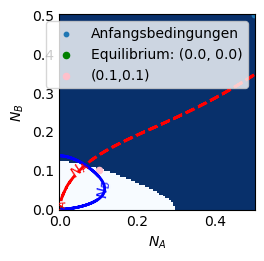

0.35


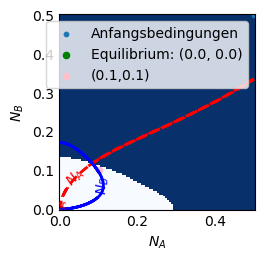

0.4


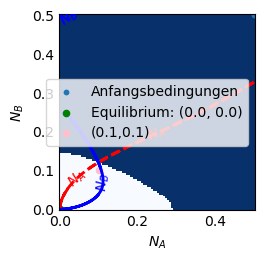

0.45


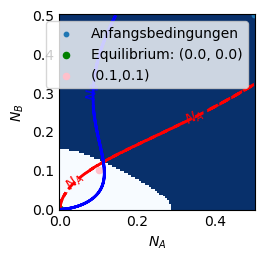

0.5


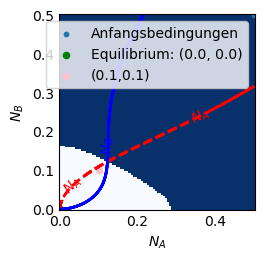

In [58]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
disp_rates = np.linspace(0.3,0.5,5)

for disp in disp_rates:
    print(disp)
    params['disp'] = disp
    create_and_plot_basin_of_attraction(params = params, res = 100, res_traj = 10, upper_bound_A = 0.5, upper_bound_B = 0.5, alpha = 0.4, plot_traj = False)

0.0


/tmp/ipykernel_109350/2145482181.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return (((params['r_A'] * N_A_t)/(1 + params['xi_A'] * N_A_t)) * (N_A_t / (N_A_t + params['Theta'])))
/tmp/ipykernel_109350/2145482181.py:5: RuntimeWarning: invalid value encountered in divide
  return (((params['r_A'] * N_A_t)/(1 + params['xi_A'] * N_A_t)) * (N_A_t / (N_A_t + params['Theta'])))
/tmp/ipykernel_109350/2004894631.py:73: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_109350/14973189.py:143: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


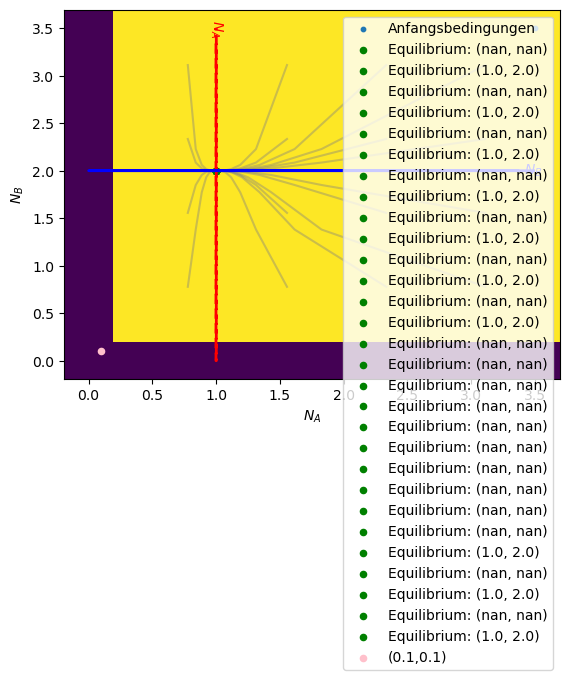

0.0


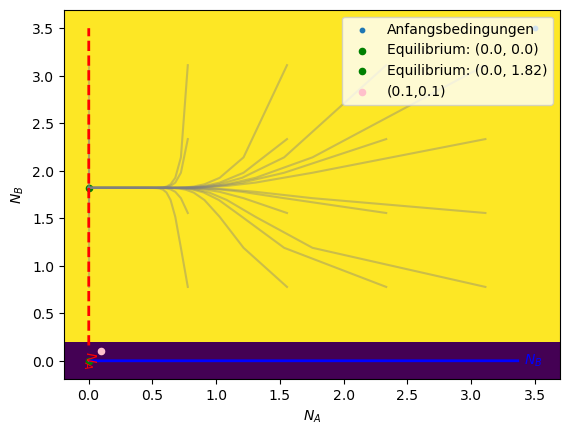

0.0


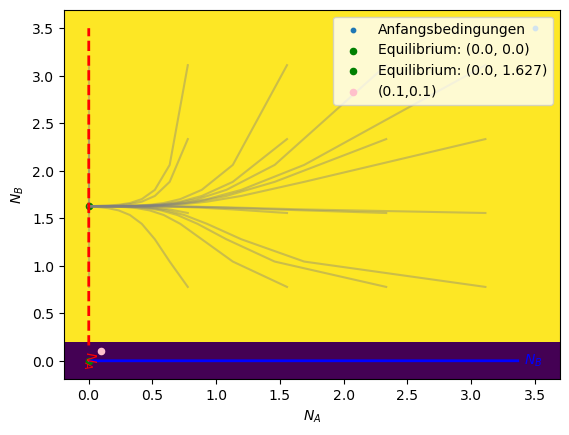

0.0


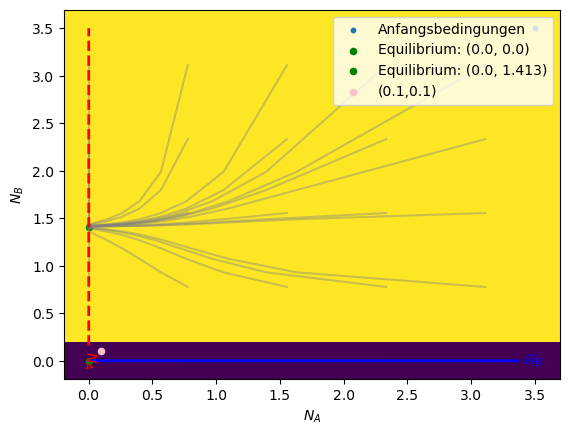

0.0


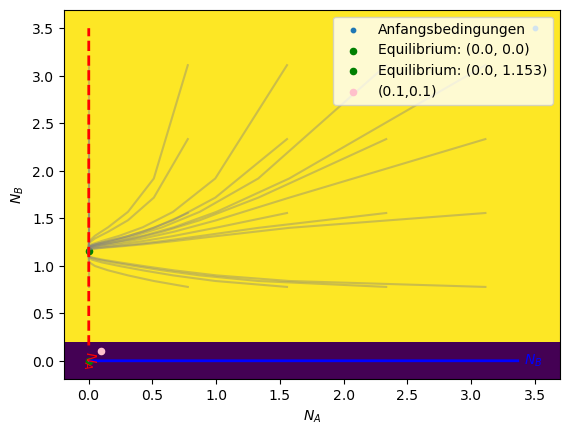

0.125


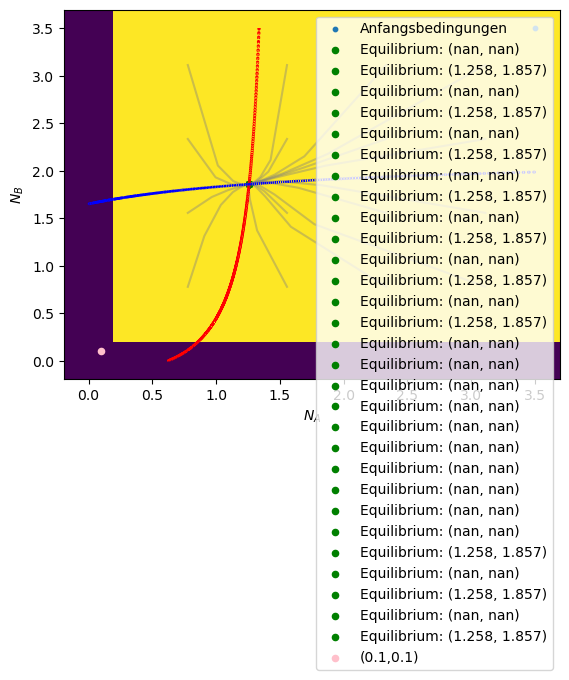

0.125


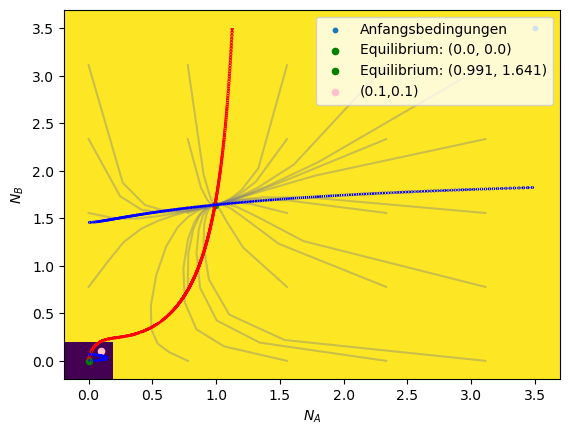

0.125


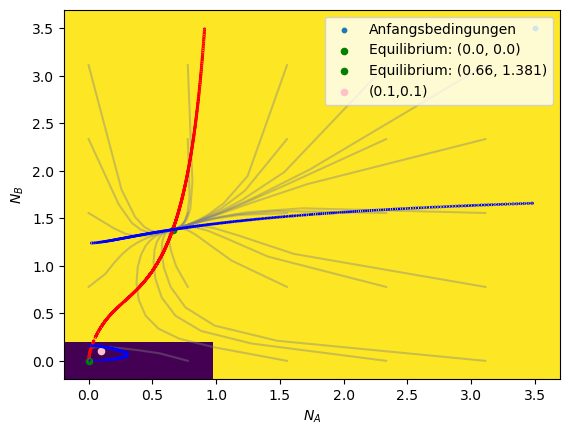

0.125


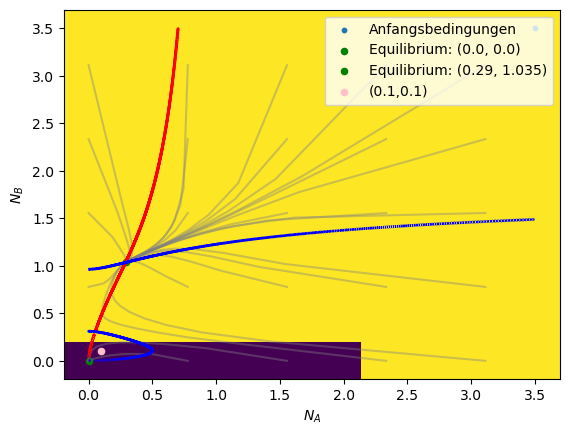

0.125


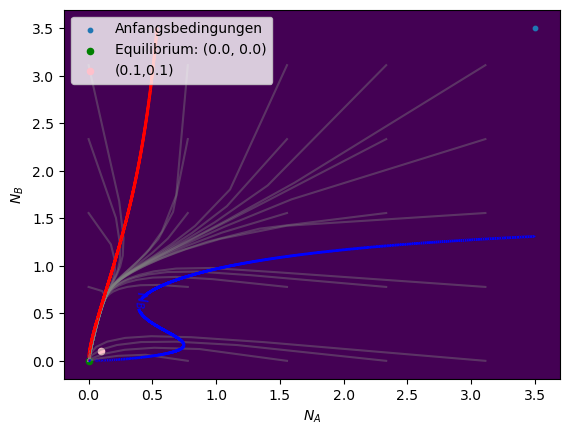

0.25


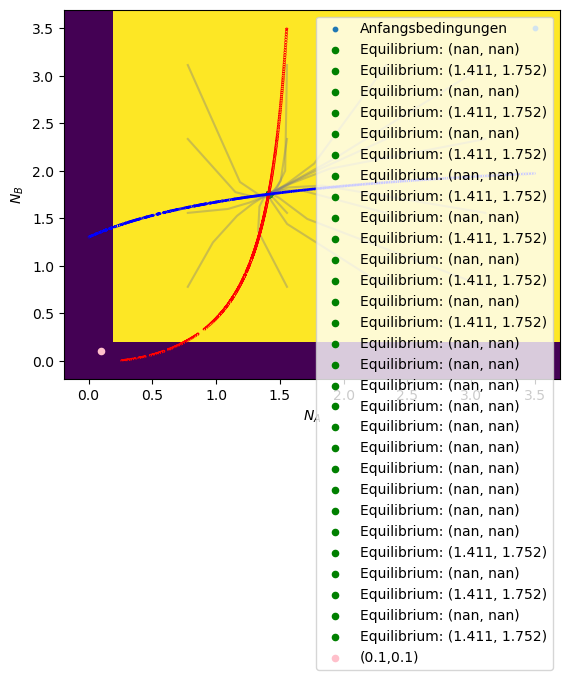

0.25


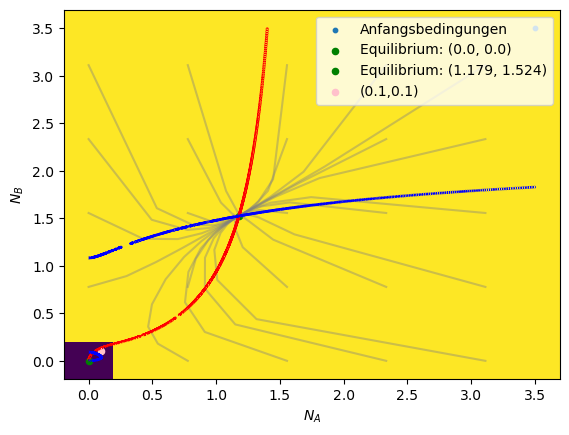

0.25


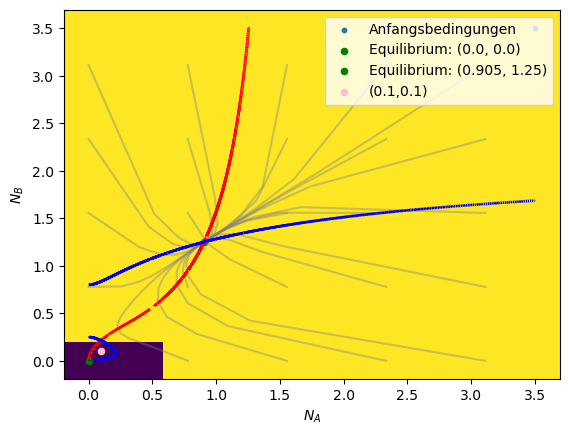

0.25


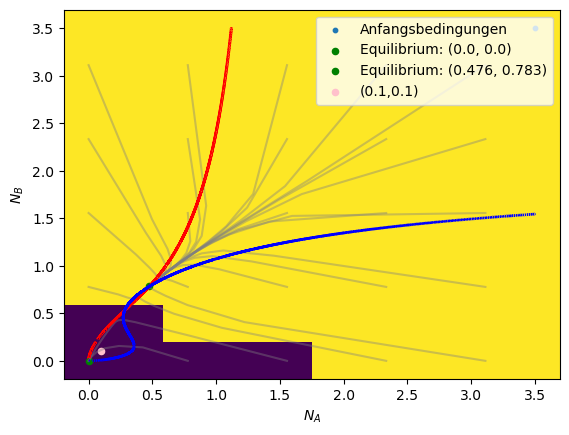

0.25


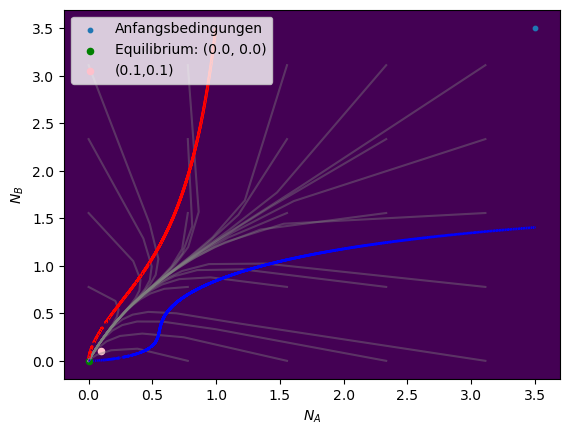

0.375


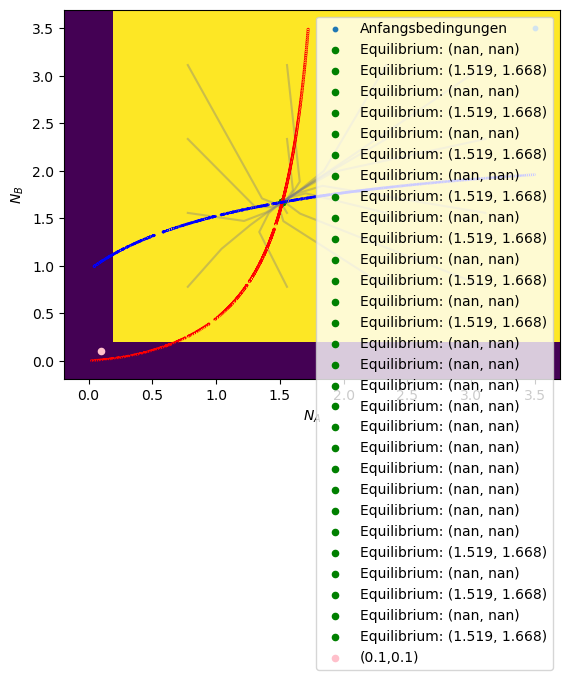

0.375


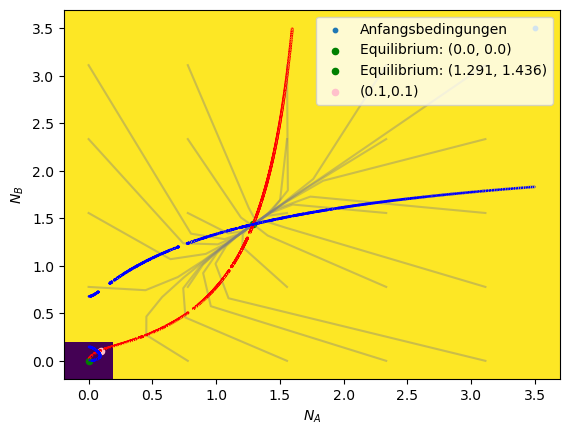

0.375


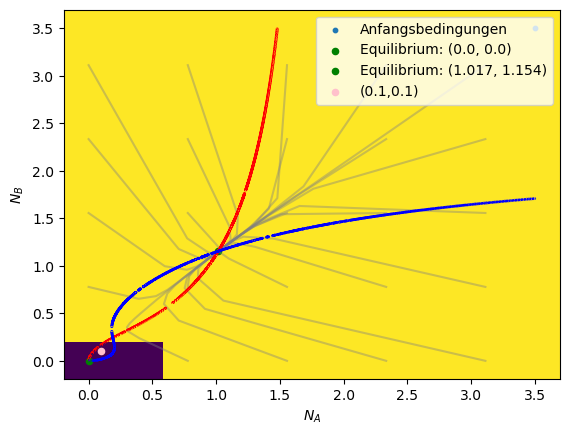

0.375


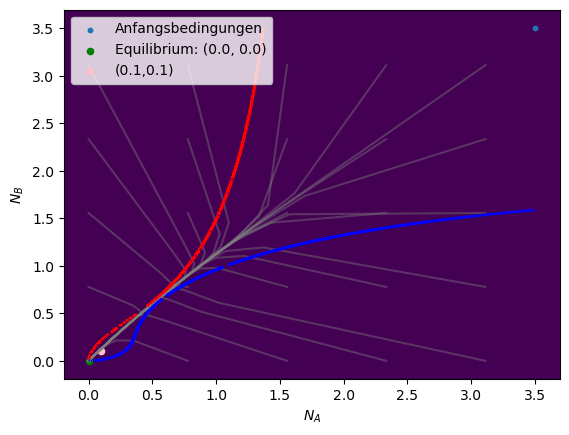

0.375


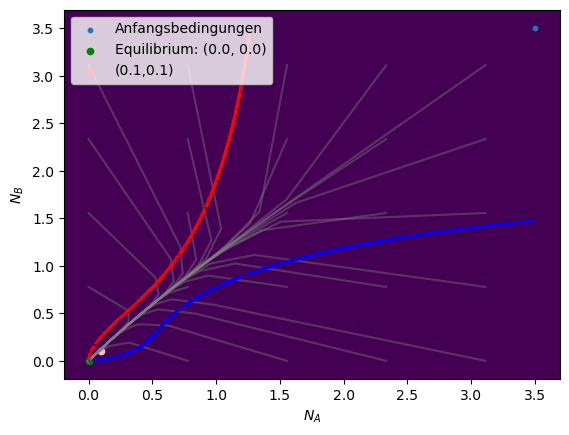

0.5


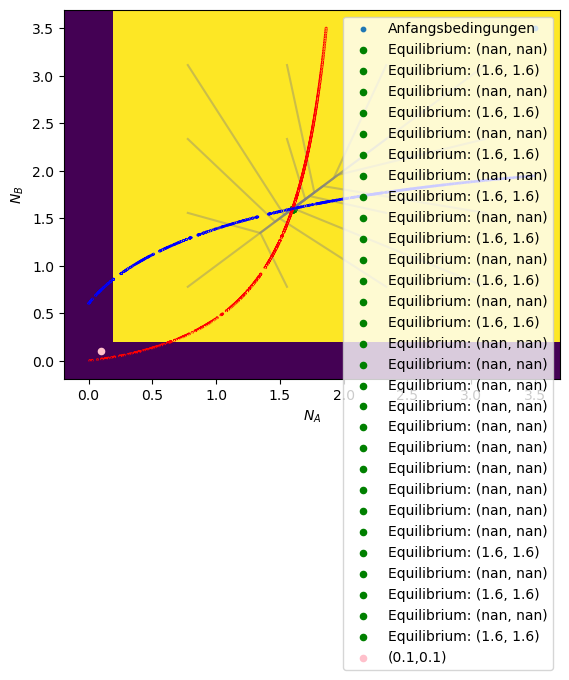

0.5


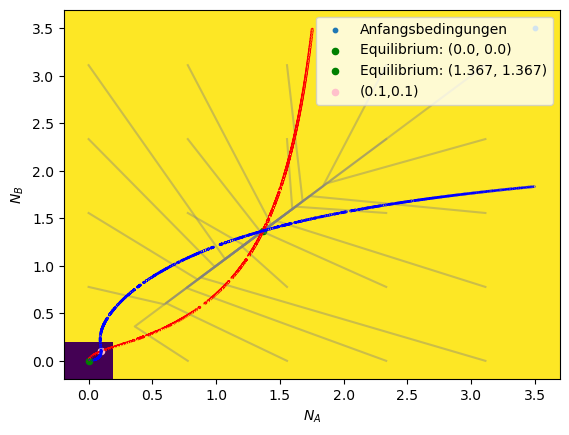

0.5


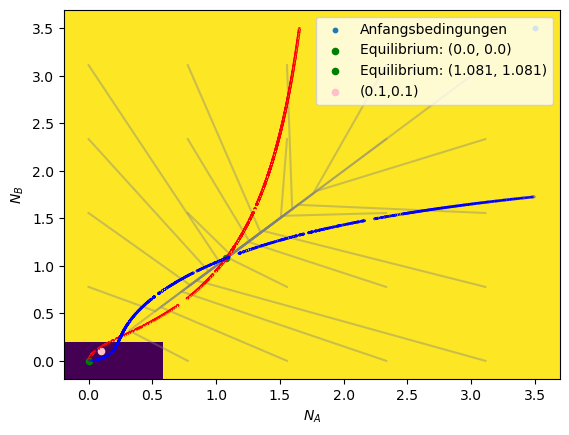

0.5


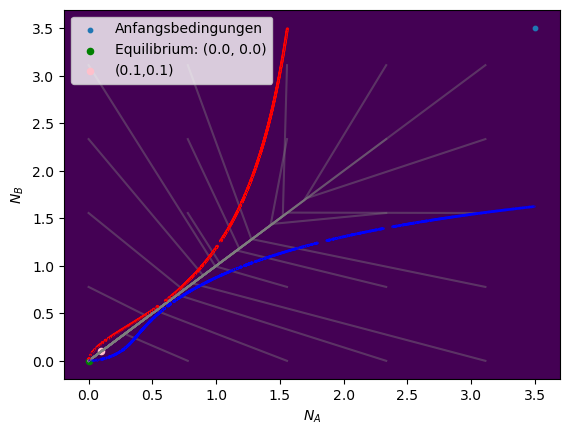

0.5


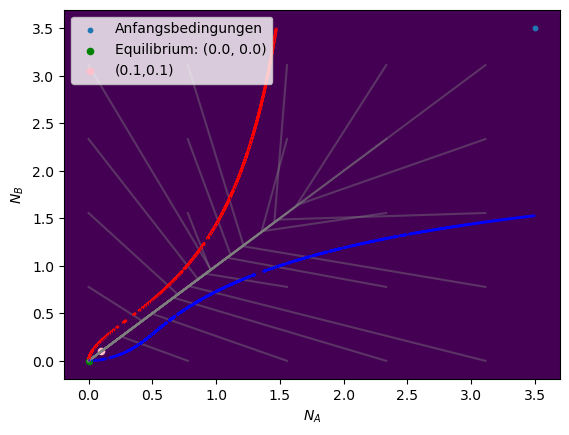

In [25]:
# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.2,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}
disp_rates = np.linspace(0.0,0.5,5)
thetas = np.linspace(0.0, 0.5, 5)

for disp in disp_rates:
    params['disp'] = disp
    for theta in thetas:
        print(disp)
        params['Theta'] = theta
        create_and_plot_basin_of_attraction(params = params, res = 10, res_traj = 2, upper_bound_A = 3.5, upper_bound_B = 3.5, alpha = 0.4, plot_traj = True)

norm: [[0.         0.03206438 0.05406001 ... 1.04778638 1.07656804 1.10556877]
 [0.0222456  0.0284623  0.04461513 ... 1.03188869 1.06076556 1.08985962]
 [0.03261487 0.01451408 0.02573715 ... 1.01566836 1.04448624 1.07352345]
 ...
 [0.84031885 0.81686424 0.79711939 ... 0.47294182 0.49641804 0.52076736]
 [0.86665884 0.84363583 0.82410328 ... 0.48495343 0.50732631 0.53065547]
 [0.8934592  0.87085658 0.85153323 ... 0.49889722 0.5201404  0.54241413]]
after: [[ 0.         -0.03183237 -0.05260959 ... -0.96480297 -0.99391203
  -1.02325581]
 [ 0.00872229 -0.02311008 -0.0438873  ... -0.95608068 -0.98518974
  -1.01453353]
 [ 0.02741067 -0.0044217  -0.02519892 ... -0.9373923  -0.96650136
  -0.99584514]
 ...
 [ 0.54980289  0.51797052  0.4971933  ... -0.41500008 -0.44410914
  -0.47345293]
 [ 0.55403166  0.52219929  0.50142207 ... -0.41077131 -0.43988037
  -0.46922416]
 [ 0.55813953  0.52630717  0.50552994 ... -0.40666343 -0.43577249
  -0.46511628]]


/tmp/ipykernel_109350/3031484417.py:33: RuntimeWarning: invalid value encountered in divide
  U_norm = U / euclidean_norm
/tmp/ipykernel_109350/3031484417.py:34: RuntimeWarning: invalid value encountered in divide
  V_norm = V / euclidean_norm


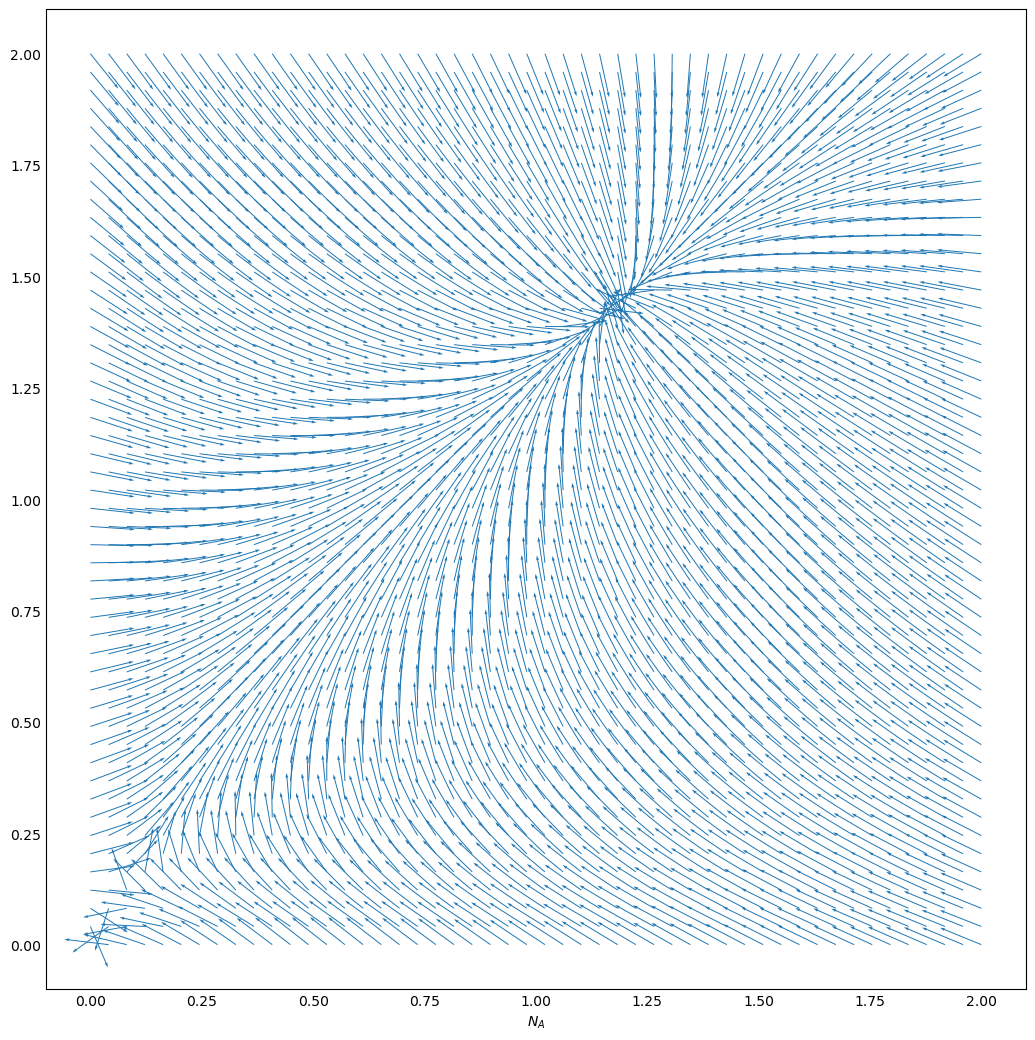

In [64]:
plt.style.use('_mpl-gallery-nogrid')

# Parameters in Figure 3
params = {
    'N_A': 0.1,
    'N_B': 0.8,
    'disp': 0.3,
    'Theta': 0.15,
    'r_A': 1.5,
    'r_B': 3.5,
    'K_A': 1.0,
    'K_B': 2.0,
}

# Update parameter
params['xi_A'] = calculate_xi(params['K_A'], params['r_A'])
params['xi_B'] = calculate_xi(params['K_B'], params['r_B'])

# make data
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
N_A, N_B = np.meshgrid(x, y)

# calculate the next iteration and then make the vector (firstIteration-zeroIteration)

U = (N_A_t_1(N_A, N_B, params) - N_A) 
V = N_B_t_1(N_A, N_B, params) - N_B
euclidean_norm = np.sqrt(np.power(U, 2) + np.power(V, 2))

print(f'norm: {euclidean_norm}')

# Norm the vectors just obtain direction
U_norm = U / euclidean_norm
V_norm = V / euclidean_norm

print(f'after: {U}')

# plot
fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(N_A, N_B, U_norm, V_norm, color="C0", angles='xy',
          scale_units='xy', scale=10, width=.001)

ax.set_xlabel('$N_A$')

plt.show()



## Divergence in the vector field
I wonder if we could determine the divergence of the vector field described above and could come up with an analytical way to describe eventually upcoming boundaries of the basins of attraction.

$$ div(\vec F) = \vec \nabla \cdot \vec F$$

In [ ]:
# Calculate and plot divergence